In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
import statsmodels.api as sm
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
import ast
from decimal import Decimal, getcontext
import requests
from scipy.stats import ttest_ind

getcontext().prec = 28  

# Data Retrieval  

In [2]:
# BTC Volatility 

def convert_timestamp_ms(timestamp):
    timestamp_in_milliseconds = timestamp
    timestamp_in_seconds = timestamp_in_milliseconds / 1000.0

    dt_object = datetime.utcfromtimestamp(timestamp_in_seconds).strftime("%Y-%m-%d")

    return str(dt_object)


btc = pd.read_csv('./data/btc_usd.csv')
btc.rename(columns = {'0': 'snapped_at', '1': 'price'}, inplace=True)
btc['datetime'] = btc['snapped_at'].apply(lambda x :convert_timestamp_ms(x))
btc = btc.loc[btc['datetime'] >= '2022-01-01'].reset_index(drop=True)
rolling_window = 2
btc['daily_returns'] = btc['price'].pct_change()
btc['vol_btc'] = btc['daily_returns'].rolling(window=rolling_window).std()
btc = btc[['datetime', 'vol_btc']].dropna().reset_index(drop=True)
btc.head()

datetime   vol_btc
0  2022-01-03  0.029186
1  2022-01-04  0.006432
2  2022-01-05  0.003761
3  2022-01-06  0.026249
4  2022-01-07  0.028285

In [3]:
# Stablecoin On Chain Supply from Defillama


usdc = pd.read_csv('./data/usdc_on_chain_info.csv')
usdt = pd.read_csv('./data/usdt_on_chain_info.csv')
busd = pd.read_csv('./data/busd_on_chain_info.csv')


In [4]:
# Price from Coingecko 

usdt_price = pd.read_csv('./data/usdt_usd.csv')

usdt_price['difference'] = usdt_price['price'].apply(lambda x : (x - 1) * 100)
usdt_price = usdt_price.loc[2420:, :].reset_index(drop=True)
usdt_price['datetime'] = usdt_price['snapped_at'].apply(lambda x : x.split(' ')[0])
usdt_price['datetime'] = pd.to_datetime(usdt_price['datetime'])


usdc_price = pd.read_csv('./data/binance_spot_usdc_usdt.csv')[['datetime', 'price']]

usdc_price.rename(columns = {'price': 'USDC'}, inplace=True)
usdc_price['datetime'] = pd.to_datetime(usdc_price['datetime'])
usdc_price = pd.merge(usdc_price, usdt_price, on = 'datetime')
usdc_price['USDC_Close'] = usdc_price['USDC'] * usdc_price['price']
usdc_price = usdc_price.loc[usdc_price['datetime'] >= '2022-01-01'].reset_index(drop=True)
usdc_price['difference'] = usdc_price['USDC_Close'].apply(lambda x : (x - 1) * 100)


busd_price = pd.read_csv('./data/binance_spot_busd_usdt.csv')[['datetime', 'CLOSE']]
busd_price.rename(columns = {'CLOSE': 'BUSD'}, inplace=True)
busd_price['datetime'] = pd.to_datetime(busd_price['datetime'])
busd_price = pd.merge(busd_price, usdt_price, on = 'datetime')
busd_price['BUSD_Close'] = busd_price['BUSD'] * busd_price['price']
busd_price = busd_price.loc[busd_price['datetime'] >= '2022-01-01'].reset_index(drop=True)
busd_price['difference'] = busd_price['BUSD_Close'].apply(lambda x : (x - 1) * 100)


# Circulating Supply 

sc_df = pd.read_csv('./data/sc_supply.csv')
sc_df['datetime'] = pd.to_datetime(sc_df['datetime'])
change_df = sc_df[['usdt_mcap', 'usdc_mcap', 'busd_mcap']].diff().cumsum()
change_df['datetime'] = sc_df['datetime']
change_df


usdt_mcap     usdc_mcap     busd_mcap   datetime
0             NaN           NaN           NaN 2021-12-26
1    5.544695e+07 -1.093322e+08  2.235493e+07 2021-12-27
2   -4.665662e+07 -4.353010e+08  1.818531e+08 2021-12-28
3    1.030156e+08 -4.067442e+08  2.316888e+08 2021-12-29
4   -1.044358e+07 -4.648585e+08 -1.028638e+08 2021-12-30
..            ...           ...           ...        ...
725  1.287092e+10 -1.766119e+10 -1.384415e+10 2023-12-21
726  1.298006e+10 -1.777967e+10 -1.384300e+10 2023-12-22
727  1.311441e+10 -1.750214e+10 -1.384513e+10 2023-12-23
728  1.320612e+10 -1.749589e+10 -1.384298e+10 2023-12-24
729  1.323877e+10 -1.747236e+10 -1.384606e+10 2023-12-25

[730 rows x 4 columns]

In [5]:
# Basis from Binance / Bybit

usdt_usd = pd.read_csv('./data/usdt_usd.csv')

usdt_usd['datetime'] = usdt_usd['snapped_at'].apply(lambda x : x.split(' ')[0])
usdt_usd['datetime'] = pd.to_datetime(usdt_usd['datetime'])
usdt_usd.rename(columns = {'price': 'USDT'}, inplace=True)
usdt_usd = usdt_usd[['datetime', 'USDT']]


usdc_usd = pd.read_csv('./data/usdc_usd.csv')

usdc_usd['datetime'] = usdc_usd['snapped_at'].apply(lambda x : x.split(' ')[0])
usdc_usd['datetime'] = pd.to_datetime(usdc_usd['datetime'])
usdc_usd.rename(columns = {'price': 'USDC'}, inplace=True)
usdc_usd = usdc_usd[['datetime', 'USDC']]


columns = ['fundingRate', 'price_spot', 'volume_spot', 'price_perps', 'volume_perps', 'trades_perps']

usdc_basis_df = pd.read_csv('./data/usdc_basis_df.csv')
usdc_basis_df[columns] = usdc_basis_df[columns].astype(float)


usdt_basis_df = pd.read_csv('./data/usdt_basis_df.csv')


busd_basis_df = pd.read_csv('./data/busd_basis_df.csv')
busd_basis_df['datetime'] = pd.to_datetime(busd_basis_df['datetime'])
busd_basis_df = busd_basis_df.tail(-1).reset_index(drop=True)
columns = ['fundingRate', 'price_spot', 'volume_spot', 'price_perps', 'volume_perps']
busd_basis_df[columns] = busd_basis_df[columns].astype(float)


In [6]:
# Treasuries 

interest_df_2022 = pd.read_csv('./data/dailytbills_2022.csv')
interest_df_2023 = pd.read_csv('./data/dailytbills_2023.csv')
interest_df = pd.concat([interest_df_2022, interest_df_2023], ignore_index=True)
interest_df = interest_df[['Date', '4 WEEKS COUPON EQUIVALENT', '8 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT']].sort_values(by = 'Date').reset_index(drop=True)
interest_df['Date'] = pd.to_datetime(interest_df['Date'])


# AAVE 

usdt_interest_df = pd.read_csv('./data/usdt_lending.csv')[['Day', 'Lending Rate']]
usdt_interest_df['datetime'] = usdt_interest_df['Day'].apply(lambda x : x.split(' ')[0])
usdt_interest_df['datetime'] = pd.to_datetime(usdt_interest_df['datetime'])
usdt_interest_df.rename(columns = {'Lending Rate': 'AAVE_USDT'}, inplace=True)

usdc_interest_df = pd.read_csv('./data/usdc_lending.csv')[['Day', 'Lending Rate']]
usdc_interest_df['datetime'] = usdc_interest_df['Day'].apply(lambda x : x.split(' ')[0])
usdc_interest_df['datetime'] = pd.to_datetime(usdc_interest_df['datetime'])
usdc_interest_df.rename(columns = {'Lending Rate': 'AAVE_USDC'}, inplace=True)


# Venus (BUSD)

busd_interest_df = pd.read_csv('./data/busd_lending_rates.csv')[['datetime', 'apy']]
busd_interest_df.rename(columns = {'apy': 'Venus_BUSD'}, inplace = True)
busd_interest_df['datetime'] = pd.to_datetime(busd_interest_df['datetime'])
busd_interest_df = busd_interest_df.loc[busd_interest_df['Venus_BUSD'] >0]

In [7]:
# Gas 

bsc_gas = pd.read_csv('./data/bsc_gas.csv')

from datetime import datetime

bsc_gas['datetime'] = bsc_gas['Date(UTC)'].apply(lambda x :datetime.strptime(x, "%m/%d/%Y").strftime("%Y-%m-%d") )
bsc_gas = bsc_gas[['datetime', 'Value (Wei)']]
bsc_gas['datetime'] = pd.to_datetime(bsc_gas['datetime'])
bsc_gas.rename(columns = {'Value (Wei)': 'bsc_gas'}, inplace=True)
bsc_gas['bsc_gas'] = bsc_gas['bsc_gas'].astype(float)
bsc_gas.head()

eth_gas = pd.read_csv('./data/eth_gas.csv')

eth_gas['datetime'] = eth_gas['Date(UTC)'].apply(lambda x :datetime.strptime(x, "%m/%d/%Y").strftime("%Y-%m-%d") )
eth_gas = eth_gas[['datetime', 'Value (Wei)']]
eth_gas['datetime'] = pd.to_datetime(eth_gas['datetime'])
eth_gas.rename(columns = {'Value (Wei)': 'eth_gas'}, inplace=True)
eth_gas['eth_gas'] = eth_gas['eth_gas'].astype(float)
eth_gas.tail()

datetime       eth_gas
3062 2023-12-17  4.303544e+10
3063 2023-12-18  6.513584e+10
3064 2023-12-19  5.946187e+10
3065 2023-12-20  5.990430e+10
3066 2023-12-21  4.467768e+10

# Data Visualisation 

In [8]:
cols = usdc.columns
circulating_supply_cols = [ i for i in cols if 'circulating' in i]
usdc_df = usdc[circulating_supply_cols]
usdc_df['datetime'] = pd.to_datetime(usdc['datetime'])
plt.figure(figsize=(10, 6))

plt.fill_between(usdc_df['datetime'], 0, usdc_df['circulating_Ethereum'], label='Ethereum', alpha=0.7)
plt.fill_between(usdc_df['datetime'], usdc_df['circulating_Ethereum'], usdc_df['circulating_Ethereum'] + usdc_df['circulating_Polygon'], label='Polygon', alpha=0.7)
plt.fill_between(usdc_df['datetime'], usdc_df['circulating_Ethereum'] + usdc_df['circulating_Polygon'], usdc_df['circulating_Ethereum'] + usdc_df['circulating_Polygon'] + usdc_df['circulating_BSC'], label='BSC', alpha=0.7)
plt.fill_between(usdc_df['datetime'], usdc_df['circulating_Ethereum'] + usdc_df['circulating_Polygon'], usdc_df['circulating_Ethereum'] + usdc_df['circulating_Polygon'] + usdc_df['circulating_BSC']+ usdc_df['circulating_Tron'], label='Tron', alpha=0.7)

plt.xlabel('Datetime')
plt.ylabel('Circulating Supply')
plt.title('Circulating Supply of USDC')
plt.legend()

plt.show()

/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/768425732.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usdc_df['datetime'] = pd.to_datetime(usdc['datetime'])


In [9]:
cols = usdt.columns
circulating_supply_cols = [ i for i in cols if 'circulating' in i]
usdt_df = usdt[circulating_supply_cols]
usdt_df['datetime'] = pd.to_datetime(usdt['datetime'])
plt.figure(figsize=(10, 6))

plt.fill_between(usdt_df['datetime'], 0, usdt_df['circulating_Ethereum'], label='Ethereum', alpha=0.7)
plt.fill_between(usdt_df['datetime'], usdt_df['circulating_Ethereum'], usdt_df['circulating_Ethereum'] + usdt_df['circulating_Polygon'], label='Polygon', alpha=0.7)
plt.fill_between(usdt_df['datetime'], usdt_df['circulating_Ethereum'] + usdt_df['circulating_Polygon'], usdt_df['circulating_Ethereum'] + usdt_df['circulating_Polygon'] + usdt_df['circulating_BSC'], label='BSC', alpha=0.7)
plt.fill_between(usdt_df['datetime'], usdt_df['circulating_Ethereum'] + usdt_df['circulating_Polygon'], usdt_df['circulating_Ethereum'] + usdt_df['circulating_Polygon'] + usdt_df['circulating_BSC']+ usdt_df['circulating_Tron'], label='Tron', alpha=0.7)

plt.xlabel('Datetime')
plt.ylabel('Circulating Supply')

plt.title('Circulating Supply of USDT')
plt.legend()

plt.show()

/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/2807029163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usdt_df['datetime'] = pd.to_datetime(usdt['datetime'])


In [10]:
cols = busd.columns
circulating_supply_cols = [ i for i in cols if 'circulating' in i]
busd_df = busd[circulating_supply_cols]
busd_df['datetime'] = pd.to_datetime(busd['datetime'])
plt.figure(figsize=(10, 6))

plt.fill_between(busd_df['datetime'], 0, busd_df['circulating_Ethereum'], label='Ethereum', alpha=0.7)
plt.fill_between(busd_df['datetime'], busd_df['circulating_Ethereum'], busd_df['circulating_Ethereum'] + busd_df['circulating_Polygon'], label='Polygon', alpha=0.7)
plt.fill_between(busd_df['datetime'], busd_df['circulating_Ethereum'] + busd_df['circulating_Polygon'], busd_df['circulating_Ethereum'] + busd_df['circulating_Polygon'] + busd_df['circulating_BSC'], label='BSC', alpha=0.7)

plt.xlabel('Datetime')
plt.ylabel('Circulating Supply')
plt.title('Circulating Supply of BUSD')
plt.legend()

plt.show()

/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/2017685597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  busd_df['datetime'] = pd.to_datetime(busd['datetime'])


In [11]:
usdc_circulating_supply = usdc_df.set_index('datetime').sum(axis=1).reset_index()
usdc_circulating_supply.rename(columns = {0:'usdc_circulatingsupply'}, inplace=True)

usdt_circulating_supply = usdt_df.set_index('datetime').sum(axis=1).reset_index()
usdt_circulating_supply.rename(columns = {0:'usdt_circulatingsupply'}, inplace=True)

busd_circulating_supply = busd_df.set_index('datetime').sum(axis=1).reset_index()
busd_circulating_supply.rename(columns = {0:'busd_circulatingsupply'}, inplace=True)

circulating_supply = usdc_circulating_supply
circulating_supply = pd.merge(usdt_circulating_supply, circulating_supply, on = 'datetime')
circulating_supply = pd.merge(busd_circulating_supply, circulating_supply, on = 'datetime')
circulating_supply['datetime'] = pd.to_datetime(circulating_supply['datetime'])
circulating_supply.head()

datetime  busd_circulatingsupply  usdt_circulatingsupply  \
0 2022-05-12            1.672728e+10            7.261152e+10   
1 2022-05-13            1.706381e+10            7.239367e+10   
2 2022-05-14            1.755322e+10            6.969138e+10   
3 2022-05-15            1.767711e+10            6.874818e+10   
4 2022-05-16            1.767668e+10            6.878520e+10   

   usdc_circulatingsupply  
0            4.096549e+10  
1            4.096549e+10  
2            4.179719e+10  
3            4.205002e+10  
4            4.211456e+10

# USDC Depeg - Major Events

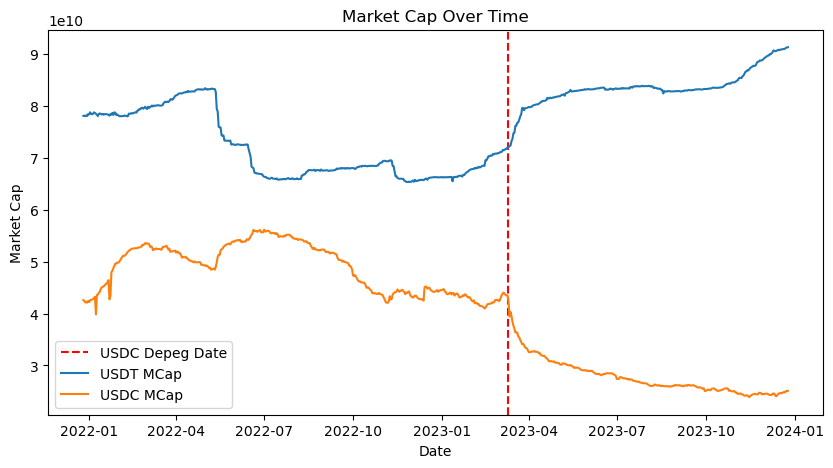

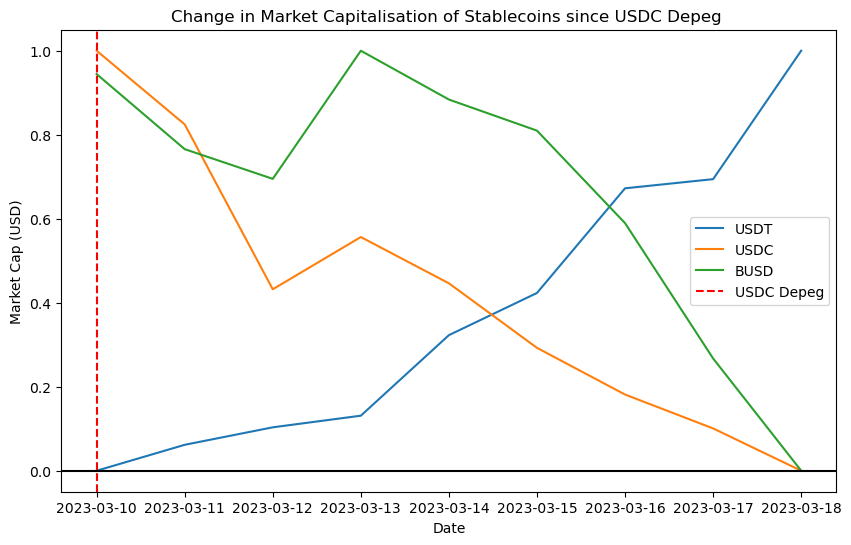

In [12]:
usdc_depeg_date =  '2023-03-10'
sub_df = sc_df[['datetime', 'usdt_mcap', 'usdc_mcap']].set_index('datetime')
plt.figure(figsize=(10, 5))
plt.axvline(x=pd.to_datetime(usdc_depeg_date), color='r', linestyle='--', label='USDC Depeg Date')
plt.plot(pd.to_datetime(sub_df.index), sub_df['usdt_mcap'], label = 'USDT MCap')

plt.plot(pd.to_datetime(sub_df.index), sub_df['usdc_mcap'], label = 'USDC MCap')
plt.title('Market Cap Over Time')
plt.xlabel('Date')
plt.ylabel('Market Cap')
plt.legend()
plt.show()


ftx_change_df = sc_df.loc[sc_df['datetime'] >= '2022-11-01'].reset_index(drop=True)
ftx_change_df = ftx_change_df.loc[ftx_change_df['datetime'] <= '2022-12-01'].reset_index(drop=True)

columns_to_normalize = ['usdt_mcap', 'usdc_mcap', 'busd_mcap']

scaler = MinMaxScaler()
ftx_change_df[columns_to_normalize] = scaler.fit_transform(ftx_change_df[columns_to_normalize])

plt.figure(figsize=(10,6))
plt.plot(ftx_change_df['datetime'], ftx_change_df['usdt_mcap'], label = 'USDT')
plt.plot(ftx_change_df['datetime'], ftx_change_df['usdc_mcap'], label = 'USDC')
plt.plot(ftx_change_df['datetime'], ftx_change_df['busd_mcap'], label = 'BUSD')
plt.axhline(y = 0, color = 'black')
plt.xlabel('Date')
plt.ylabel('Market Cap (USD)')
plt.axvline(pd.to_datetime("2022-11-02"), color='red', linestyle='--', label='FTX Collapse')

plt.title('Change in Market Capitalisation of Stablecoins since FTX Collapse ')

plt.legend()

usdc_change_df = sc_df.loc[sc_df['datetime'] >= '2023-03-10'].reset_index(drop=True)
usdc_change_df = usdc_change_df.loc[usdc_change_df['datetime'] <= '2023-03-18'].reset_index(drop=True)

columns_to_normalize = ['usdt_mcap', 'usdc_mcap', 'busd_mcap']

scaler = MinMaxScaler()
usdc_change_df[columns_to_normalize] = scaler.fit_transform(usdc_change_df[columns_to_normalize])

plt.figure(figsize=(10,6))
plt.plot(usdc_change_df['datetime'], usdc_change_df['usdt_mcap'], label = 'USDT')
plt.plot(usdc_change_df['datetime'], usdc_change_df['usdc_mcap'], label = 'USDC')
plt.plot(usdc_change_df['datetime'], usdc_change_df['busd_mcap'], label = 'BUSD')
plt.axhline(y = 0, color = 'black')
plt.xlabel('Date')
plt.ylabel('Market Cap (USD)')
plt.axvline(pd.to_datetime("2023-03-10"), color='red', linestyle='--', label='USDC Depeg')

plt.title('Change in Market Capitalisation of Stablecoins since USDC Depeg ')

plt.legend()


plt.figure(figsize=(10,6))
plt.plot(change_df['datetime'], change_df['usdt_mcap'], label = 'USDT')
plt.plot(change_df['datetime'], change_df['usdc_mcap'], label = 'USDC')
plt.plot(change_df['datetime'], change_df['busd_mcap'], label = 'BUSD')
plt.axhline(y = 0, color = 'black')
plt.xlabel('Date')
plt.ylabel('Market Cap (USD)')
plt.axvline(pd.to_datetime("2023-03-10"), color='red', linestyle='--', label='SVB and USDC Depeg')
plt.axvline(pd.to_datetime("2022-11-02"), color='red', linestyle='--', label='FTX Collapse')

plt.title('Change in Market Capitalisation of Stablecoins over time')

plt.legend()

# Stablecoin Prices (Spot)

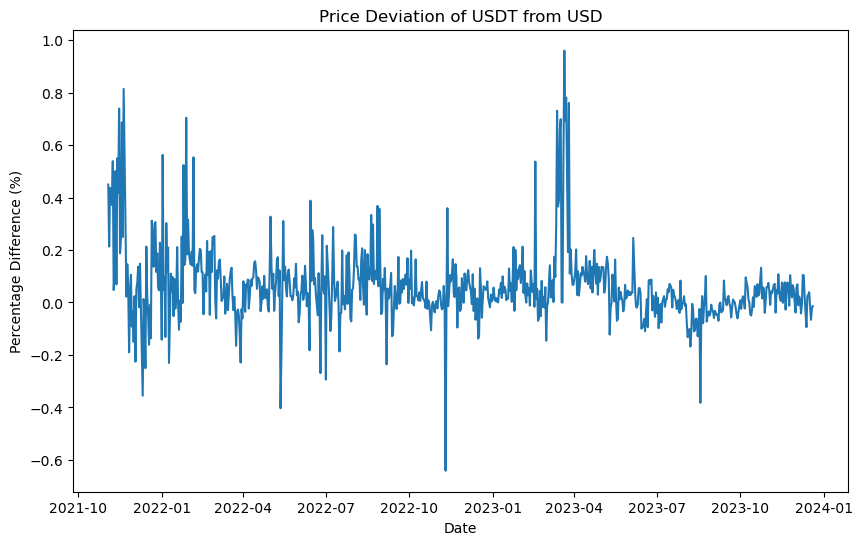

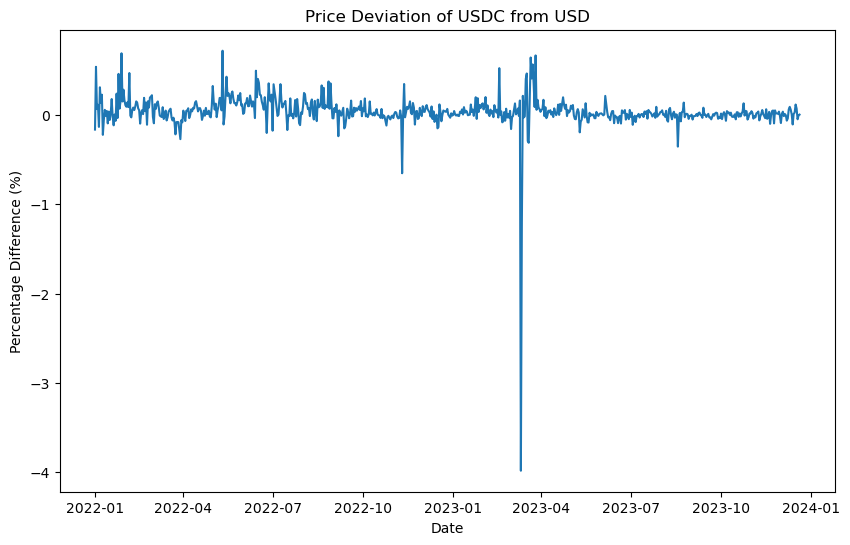

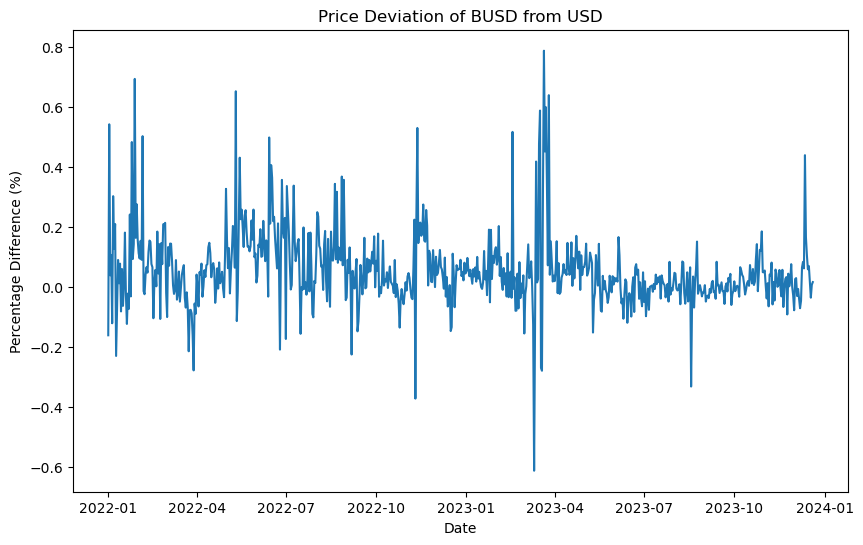

In [13]:
def plot_price(df, stablecoin): 
    plt.figure(figsize=(10,6))
    plt.plot(df['datetime'], df['difference'])
    plt.xlabel('Date')
    plt.ylabel('Percentage Difference (%)')
    plt.title(f'Price Deviation of {stablecoin} from USD')
    

plot_price(usdt_price, 'USDT')
plot_price(usdc_price, 'USDC')
plot_price(busd_price, 'BUSD')

In [14]:
usdt_price.rename(columns = {'price': 'USDT'}, inplace=True)
prices = usdt_price
prices['datetime'] = prices['datetime'].astype(str)
usdc_price['datetime'] = usdc_price['datetime'].astype(str)
usdc_price = usdc_price[['datetime', 'USDC_Close']]
usdc_price.rename(columns = {'USDC_Close': 'USDC'}, inplace=True)
prices = pd.merge(prices, usdc_price, on = 'datetime')
busd_price['datetime'] = busd_price['datetime'].astype(str)
busd_price = busd_price[['datetime', 'BUSD_Close']]
busd_price.rename(columns = {'BUSD_Close': 'BUSD'}, inplace=True)
prices = pd.merge(prices, busd_price, on = 'datetime')
prices = prices[['datetime', 'USDT', 'USDC', 'BUSD']]

In [15]:
prices.head()

datetime      USDT      USDC      BUSD
0  2022-01-01  0.998582  0.998382  0.998382
1  2022-01-02  1.005624  1.005422  1.005422
2  2022-01-03  1.000483  1.000684  1.000383
3  2022-01-04  1.000963  1.001163  1.001063
4  2022-01-05  0.998683  0.998683  0.998783

# Basis

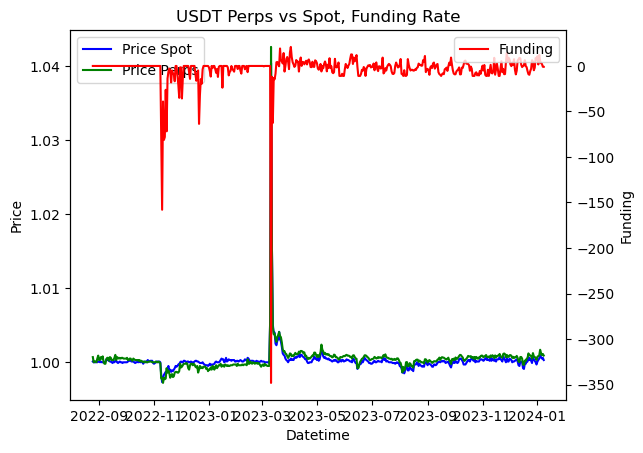

In [16]:
def plot(df, asset):

    fig, ax1 = plt.subplots()
    ax1.plot(df['datetime'], df['price_spot'].astype(float), label='Price Spot', color='blue')
    ax1.plot(df['datetime'], df['price_perps'].astype(float), label='Price Perps', color='green')

    ax2 = ax1.twinx()

    df['datetime'] = pd.to_datetime(df['datetime'])
    ax2.plot(df['datetime'], df['fundingRate'].astype(float), label='Funding', color='red')

    ax1.set_xlabel('Datetime')
    ax1.set_ylabel('Price', color='black')
    ax2.set_ylabel('Funding', color='black')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title(f'{asset} Perps vs Spot, Funding Rate')
    plt.show()
    
usdc_basis_df['datetime']= pd.to_datetime(usdc_basis_df['datetime'])
usdt_basis_df['datetime'] = pd.to_datetime(usdt_basis_df['datetime'])

usdc_basis_df = usdc_basis_df.drop_duplicates('datetime').reset_index(drop=True)
usdt_basis_df = usdt_basis_df.drop_duplicates('datetime').reset_index(drop=True)

plot(usdt_basis_df, 'USDT')

In [17]:
plot(usdc_basis_df, 'USDC')

In [18]:
plot(busd_basis_df, 'BUSD')

# Interest Rates

Treasuries

In [19]:
plt.figure(figsize=(10,6))
interest_df.set_index('Date').plot()
plt.ylabel('Interest Rates (%)')
plt.title("Interest Rates Based on Duration Profiles (%)")
plt.show()


<Figure size 1000x600 with 0 Axes>

In [20]:
interest_df.rename(columns = {'4 WEEKS COUPON EQUIVALENT': 'Tbill_1_month', 
                             '8 WEEKS COUPON EQUIVALENT': 'Tbill_2_month', 
                             '13 WEEKS COUPON EQUIVALENT': 'Tbill_3_month'}, inplace=True)


AAVE/Venus Lending

In [21]:
plt.figure(figsize=(10,6))
plt.plot(usdt_interest_df['datetime'], usdt_interest_df['AAVE_USDT'])

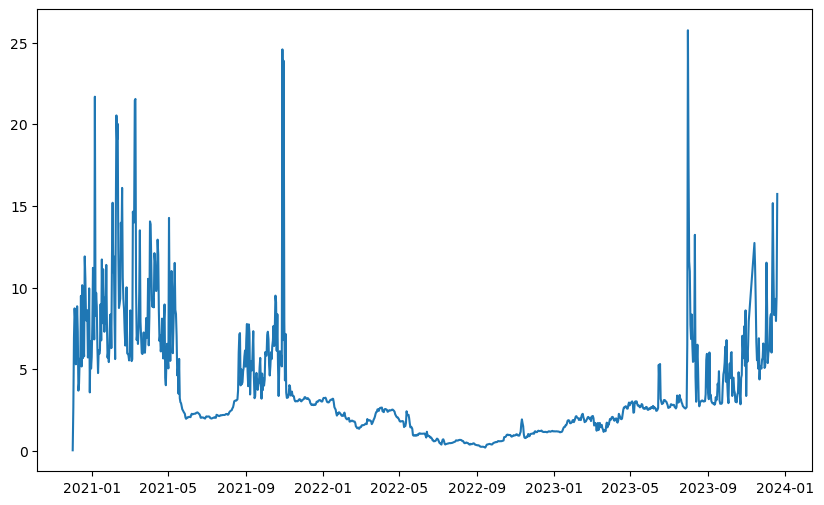

In [22]:
plt.figure(figsize=(10,6))
plt.plot(usdc_interest_df['datetime'], usdc_interest_df['AAVE_USDC'])

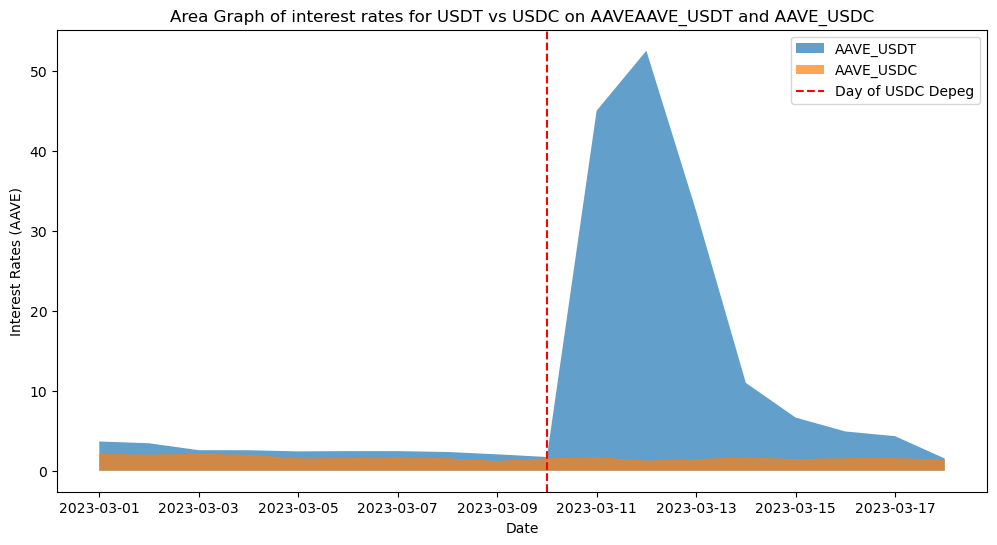

In [23]:
ftx_usdc_df = usdc_interest_df.loc[(usdc_interest_df['datetime'] >= '2023-03-01') & (usdc_interest_df['datetime'] <= '2023-03-18')][['datetime', 'AAVE_USDC']]
ftx_usdt_df = usdt_interest_df.loc[(usdt_interest_df['datetime'] >= '2023-03-01') & (usdt_interest_df['datetime'] <= '2023-03-18')][['datetime', 'AAVE_USDT']]
merged_df = pd.merge(ftx_usdt_df, ftx_usdc_df, on='datetime')
plt.figure(figsize=(12, 6)) 
plt.fill_between(ftx_usdt_df.datetime, ftx_usdt_df['AAVE_USDT'], label='AAVE_USDT', alpha=0.7)
plt.fill_between(ftx_usdc_df.datetime, ftx_usdc_df['AAVE_USDC'], label='AAVE_USDC', alpha=0.7)
plt.axvline(x = pd.to_datetime('2023-03-10'), linestyle = '--', color = 'r', label = 'Day of USDC Depeg')
plt.xlabel('Date')
plt.ylabel('Interest Rates (AAVE)')
plt.title('Area Graph of interest rates for USDT vs USDC on AAVEAAVE_USDT and AAVE_USDC')
plt.legend()
plt.show()

In [24]:
depeg_usdc_df = usdc_interest_df.loc[(usdc_interest_df['datetime'] >= '2023-03-10') & (usdc_interest_df['datetime'] <= '2023-03-18')][['datetime', 'AAVE_USDC']]
depeg_usdt_df = usdt_interest_df.loc[(usdt_interest_df['datetime'] >= '2023-03-10') & (usdt_interest_df['datetime'] <= '2023-03-18')][['datetime', 'AAVE_USDT']]

merged_df = pd.merge(depeg_usdt_df, depeg_usdc_df, on='datetime')
plt.figure(figsize=(12, 6)) 
plt.fill_between(depeg_usdt_df.datetime, depeg_usdt_df['AAVE_USDT'], label='AAVE_USDT', alpha=0.7)
plt.fill_between(depeg_usdc_df.datetime, depeg_usdc_df['AAVE_USDC'], label='AAVE_USDC', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Interest Rates (AAVE)')
plt.title('Area Graph of interest rates for USDT vs USDC on AAVE')
plt.legend()
plt.show()

In [25]:
aave_tvl = pd.read_csv('./data/aave_tvl.csv')
aave_tvl.drop(columns = ['Unnamed: 0'], inplace=True)
aave_tvl = aave_tvl.set_index('timestamp')
aave_tvl = aave_tvl.loc[(aave_tvl.index >= '2023-03-11') & (aave_tvl.index <= '2023-03-18')]
aave_usdt_df = aave_tvl['USDT_value'].reset_index()
aave_usdc_df = aave_tvl['USDC_value'].reset_index()

plt.figure(figsize=(12, 6)) 
bottom_values = aave_usdt_df['USDT_value'] / 10**6

plt.fill_between(pd.to_datetime(aave_usdt_df['timestamp']), aave_usdt_df['USDT_value'] / 10**6,
                 label='AAVE_USDT TVL', alpha=0.7, color='orange')

plt.fill_between(pd.to_datetime(aave_usdc_df['timestamp']), bottom_values,
                 bottom_values + aave_usdc_df['USDC_value'] / 10**6,
                 label='AAVE_USDC TVL', alpha=0.7, color='red')

plt.xlabel('Date')
plt.ylabel('TVL (US $M)')
plt.title('Area Graph of TVL for USDT vs USDC on AAVE (USDC Depeg)')
plt.legend()
plt.show()

# CIP Deviations


In [26]:
def calc_cip(perps, spot, interest, days):
  synthetic_rate = (((perps/spot) * (1 + interest/days))  - 1) * days
  cip = synthetic_rate - interest
  return cip

def calc_synthetic_rate(perps, spot, interest, days):
   synthetic_rate = (((perps/spot) * (1 + interest/days))  - 1) * days
   return synthetic_rate


## Lending Rates (CIP)

### Venus - BUSD

In [27]:
# import requests 
# link = 'https://yields.llama.fi/chart/483533e6-3112-44a1-beae-7cae023065a6'
# data = requests.get(link).json()['data']
# busd_interest_df = pd.DataFrame(data)
# busd_interest_df['datetime'] = busd_interest_df['timestamp'].apply(lambda x : x.split('T')[0])
# busd_interest_df.to_csv('./data/busd_lending_rates.csv')

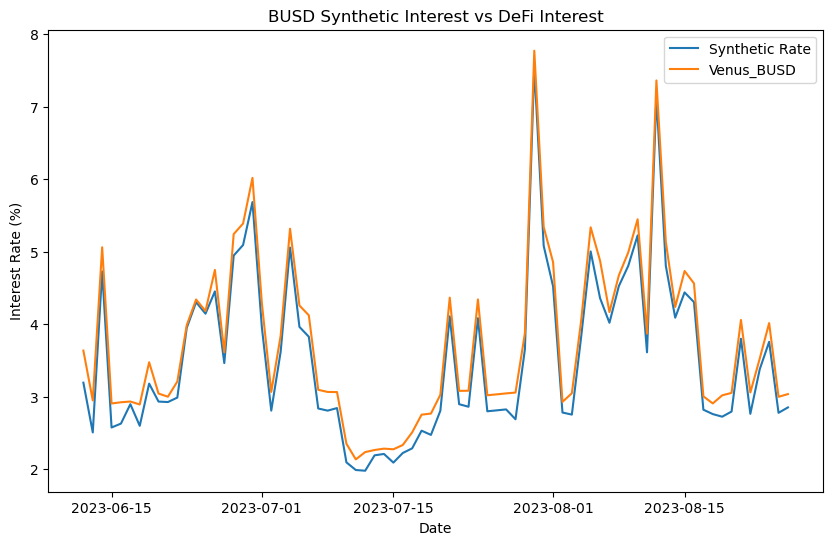

Unnamed: 0   datetime  fundingRate  price_spot  volume_spot  price_perps  \
0            2 2023-06-12   -21.742320      1.0000  21371699.02       0.9988   
1            3 2023-06-13   -33.952665      1.0002  21699754.10       0.9990   
2            4 2023-06-14    -9.996985      1.0002  20925399.22       0.9993   
3            5 2023-06-15     2.486745      1.0010  65969315.49       1.0001   
4            6 2023-06-16    -1.284435      1.0006  17715736.79       0.9998   
..         ...        ...          ...         ...          ...          ...   
72          74 2023-08-22   -10.944890      1.0005  47751012.26       0.9997   
73          75 2023-08-23   -16.261845      1.0002  54180460.48       0.9998   
74          76 2023-08-24    -8.597575      1.0005  34425611.82       0.9998   
75          77 2023-08-25     3.847465      1.0005  33928804.67       0.9999   
76          78 2023-08-26    -0.699340      1.0005  12420044.35       1.0000   

    volume_perps  Venus_BUSD  busd_cip  synthetic_rate  
0       500109.6     3.63826 -0.442366        3.195894  
1        93810.3     2.95103 -0.441453        2.509577  
2       452447.8     5.06367 -0.332991        4.730679  
3       616115.1     2.90865 -0.330787        2.577863  
4       179459.0     2.92575 -0.294164        2.631586  
..           ...         ...       ...             ...  
72       73347.0     3.06081 -0.294301        2.766509  
73       45106.9     3.52876 -0.147382        3.381378  
74       22509.9     4.01774 -0.258183        3.759557  
75       42431.5     3.00087 -0.220690        2.780180  
76      126161.0     3.03844 -0.183927        2.854513  

[77 rows x 10 columns]

In [28]:
def plotting_basis_syntheticrates(basis_df, interest_df, asset):
  asset = asset.upper()
  overall_df = pd.merge(basis_df, interest_df, on = 'datetime')
  overall_df = overall_df.tail(-1).reset_index(drop=True)
  overall_df[f'{asset.lower()}_cip'] = overall_df.apply(lambda x: calc_cip(x['price_perps'], x['price_spot'], x['Venus_BUSD'], 365), axis=1)
  overall_df['synthetic_rate'] = overall_df.apply(lambda x: calc_synthetic_rate(x['price_perps'], x['price_spot'], x['Venus_BUSD'], 365), axis=1)
  plt.figure(figsize=(10,6))
  plt.plot(overall_df['datetime'], overall_df['synthetic_rate'].astype(float), label = 'Synthetic Rate')
  plt.plot(overall_df['datetime'], overall_df['Venus_BUSD'].astype(float), label = 'Venus_BUSD')
  plt.title(f'{asset} Synthetic Interest vs DeFi Interest')
  plt.xlabel('Date')
  plt.ylabel('Interest Rate (%)')
  plt.legend()
  plt.show()
  return overall_df

busd_basis_df['datetime'] = pd.to_datetime(busd_basis_df['datetime'])
defi_busd_overall_df = plotting_basis_syntheticrates(busd_basis_df, busd_interest_df, 'BUSD')
defi_busd_overall_df

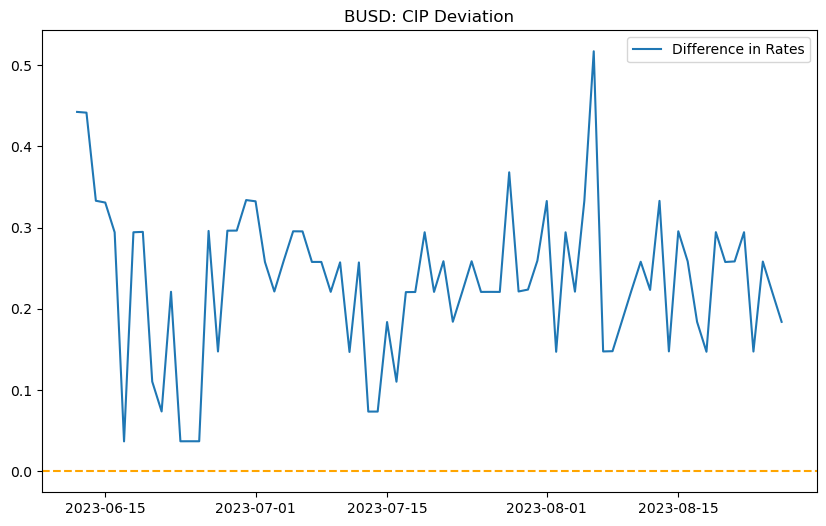

In [29]:
defi_busd_overall_df['difference'] = defi_busd_overall_df['Venus_BUSD'] - defi_busd_overall_df['synthetic_rate']
plt.figure(figsize=(10,6))
plt.plot(defi_busd_overall_df['datetime'], defi_busd_overall_df['difference'], label = 'Difference in Rates')
plt.axhline(y = 0, linestyle = '--', color='orange')
plt.title('BUSD: CIP Deviation')
plt.legend()

### USDT/USDC - AAVE

In [30]:
def basis_syntheticrates(basis_df, interest_df, asset):
  asset = asset.upper()
  overall_df = pd.merge(basis_df, interest_df, on = 'datetime')
  overall_df[f'{asset.lower()}_cip'] = overall_df.apply(lambda x: calc_cip(x['price_perps'], x['price_spot'], x[f'AAVE_{asset}'], 365), axis=1)
  overall_df['synthetic_rate'] = overall_df.apply(lambda x: calc_synthetic_rate(x['price_perps'], x['price_spot'], x[f'AAVE_{asset}'], 365), axis=1)
  return overall_df

def plotting_basis_syntheticrates(overall_df, asset):
  overall_df['datetime'] = pd.to_datetime(overall_df['datetime'])  
  plt.figure(figsize=(10,6))
  plt.plot(overall_df['datetime'], overall_df['synthetic_rate'], label='Synthetic Rate')
  plt.plot(overall_df['datetime'], overall_df[f'AAVE_{asset}'], label=f'AAVE {asset}')

  plt.title(f'{asset} Synthetic Interest vs DeFi Interest')
  plt.xlabel('Date')
  plt.ylabel('Interest Rate (%)')
  plt.legend()
  plt.show()

usdt_basis_df['datetime'] = pd.to_datetime(usdt_basis_df['datetime'])
usdc_basis_df['datetime'] = pd.to_datetime(usdc_basis_df['datetime'])

defi_usdt_overall_df = basis_syntheticrates(usdt_basis_df, usdt_interest_df, 'USDT')
defi_usdc_overall_df = basis_syntheticrates(usdc_basis_df, usdc_interest_df, 'USDC')
plotting_basis_syntheticrates(defi_usdc_overall_df, 'USDC')

<Axes: xlabel='datetime'>

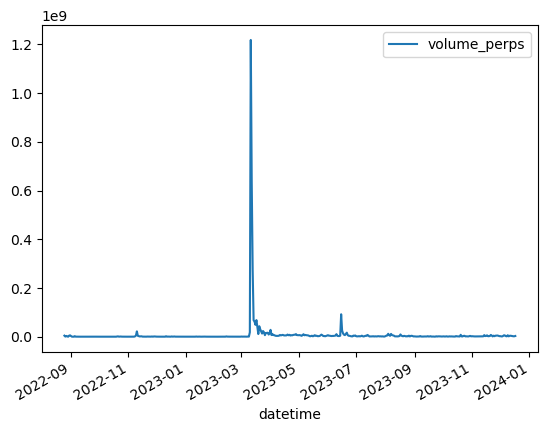

In [31]:
defi_usdt_overall_df[['datetime', 'volume_perps']].set_index('datetime').plot()

In [32]:
def cip_df(df, asset):
  asset = asset.lower()
  cip_df = df[['datetime', f'{asset}_cip']]
  cip_df.rename(columns = {'cip': f'{asset}_cip'}, inplace=True)

  plt.figure(figsize=(10,6))
  plt.plot(df['datetime'], df[f'{asset}_cip'], label = 'CIP')
  plt.title(f'{asset} CIP')
  plt.xlabel('Date')
  plt.ylabel('CIP (%)')
  plt.legend()
  plt.show()

cip_df(defi_usdc_overall_df, 'USDC')

/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/2626620443.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cip_df.rename(columns = {'cip': f'{asset}_cip'}, inplace=True)


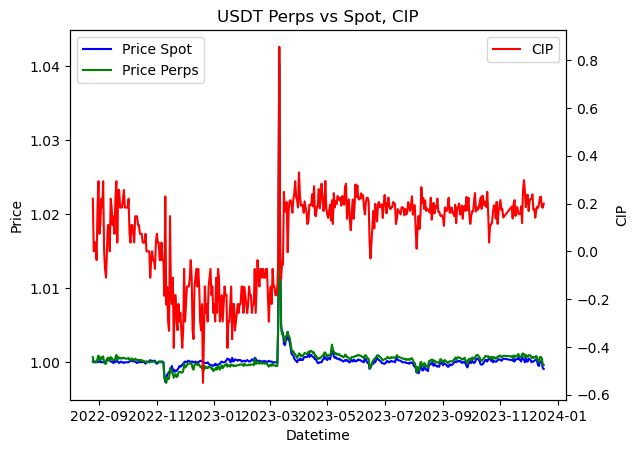

In [33]:
def multi_graph(df, asset):
  asset = asset.upper()
  fig, ax1 = plt.subplots()
  ax1.plot(df['datetime'], df['price_spot'], label='Price Spot', color='blue')
  ax1.plot(df['datetime'], df['price_perps'], label='Price Perps', color='green')

  ax2 = ax1.twinx()


  ax2.plot(df['datetime'], df[f'{asset.lower()}_cip'], label='CIP', color='red')

  ax1.set_xlabel('Datetime')
  ax1.set_ylabel('Price', color='black')
  ax2.set_ylabel('CIP', color='black')

  ax1.legend(loc='upper left')
  ax2.legend(loc='upper right')

  plt.title(f'{asset} Perps vs Spot, CIP')
  plt.show()



multi_graph(defi_usdt_overall_df, 'USDT')





Combined for the Defi

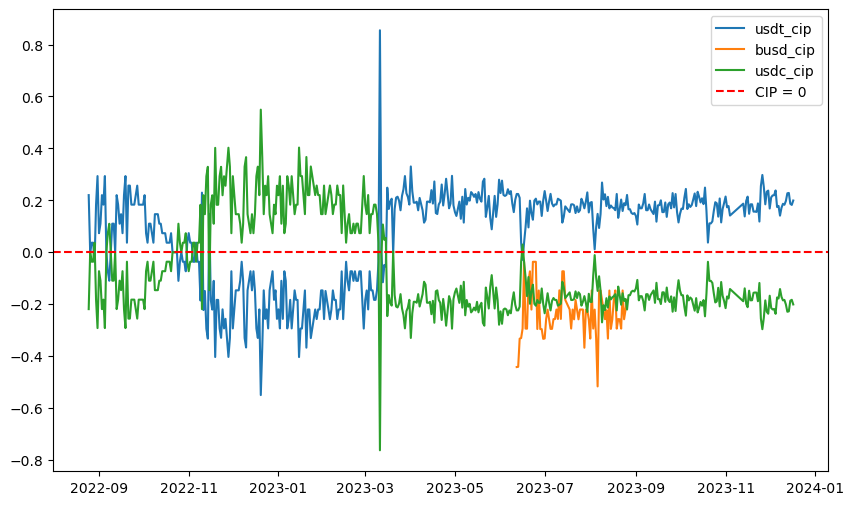

In [34]:

defi_df = defi_usdt_overall_df
defi_df.rename(columns = {'cip': 'usdt_cip'}, inplace=True)
defi_df = pd.merge(defi_df, defi_busd_overall_df, on = 'datetime', how = 'left')
defi_df.rename(columns = {'cip': 'busd_cip'}, inplace=True)
defi_df = pd.merge(defi_df, defi_usdc_overall_df, on = 'datetime', how = 'left')
defi_df.rename(columns = {'cip': 'usdc_cip'}, inplace=True)

defi_cip_df = defi_df[['datetime', 'usdt_cip', 'busd_cip', 'usdc_cip']]
plt.figure(figsize=(10,6))
plt.plot(defi_cip_df['datetime'], defi_cip_df['usdt_cip'], label = 'usdt_cip')
plt.plot(defi_cip_df['datetime'], defi_cip_df['busd_cip'], label = 'busd_cip')
plt.plot(defi_cip_df['datetime'], defi_cip_df['usdc_cip'], label = 'usdc_cip')
plt.axhline(y=0, color='red', linestyle='--', label='CIP = 0')  # Adjust color and linestyle as needed
plt.legend()
plt.show()

## US Tbills & Term Structure

Index(['datetime', 'Tbill_1_month', 'Tbill_2_month', 'Tbill_3_month'], dtype='object')


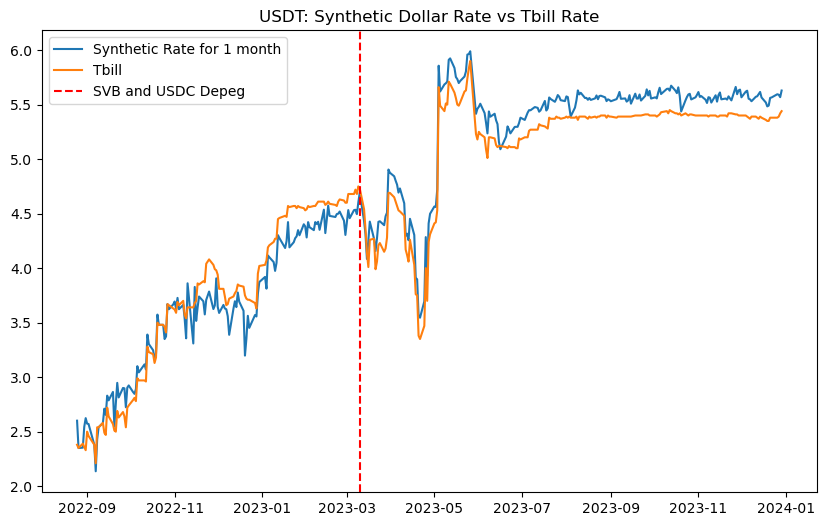

-0.07452660179996164
count    33700.000000
mean        -7.452660
std         17.080805
min        -29.566924
25%        -19.530948
50%        -15.561780
75%          3.696470
max         55.235171
Name: difference_1_month, dtype: float64
Index(['datetime', 'Tbill_1_month', 'Tbill_2_month', 'Tbill_3_month'], dtype='object')


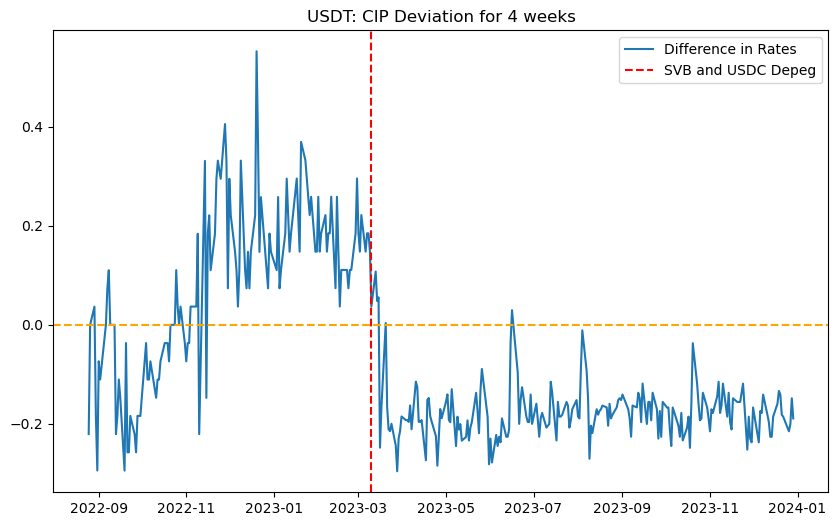

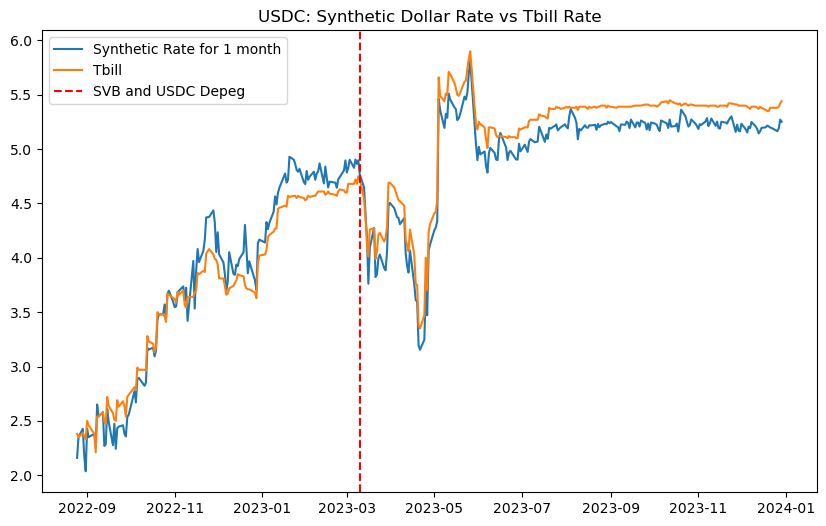

0.07443288719621223
count    33700.000000
mean         7.443289
std         17.082386
min        -55.318032
25%         -3.696839
50%         15.555244
75%         19.520598
max         29.543263
Name: difference_1_month, dtype: float64
Index(['datetime', 'Tbill_1_month', 'Tbill_2_month', 'Tbill_3_month'], dtype='object')


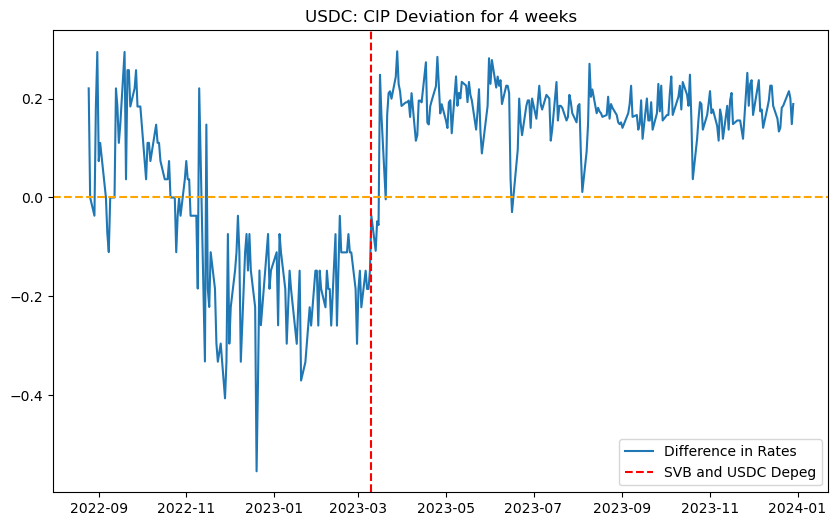

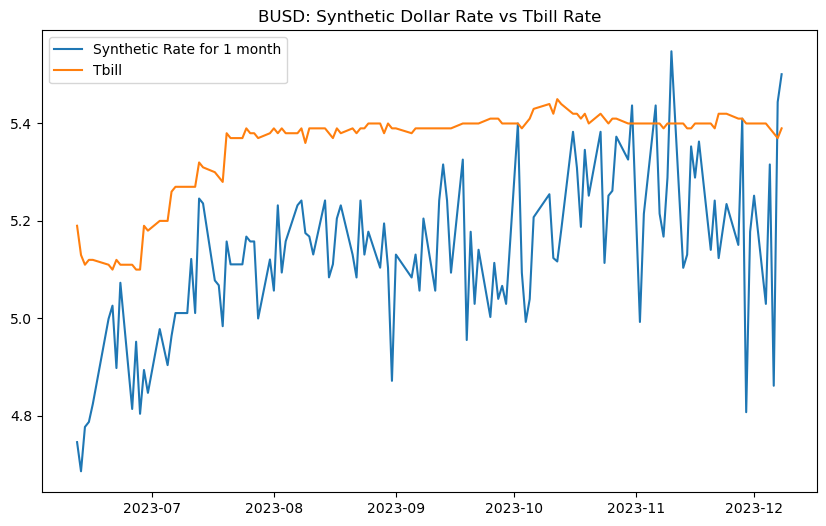

0.22334677795134095
count    12700.000000
mean        22.334678
std         12.750203
min        -14.824895
25%         14.812459
50%         22.230069
75%         29.623556
max         59.275855
Name: difference_1_month, dtype: float64


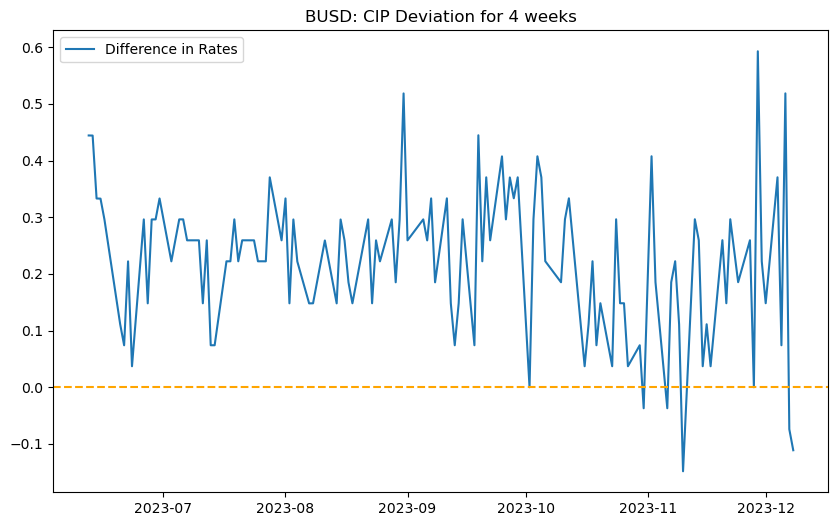

In [35]:
def plot_tbills_cip(df, interest_df, asset, time):
    interest_df = interest_df.rename(columns = {'Date': 'datetime'})
    print(interest_df.columns)
    overall_df = pd.merge(df, interest_df, on = 'datetime')
    overall_df[f'{asset.lower()}_cip'] = overall_df.apply(lambda x: calc_cip(x['price_perps'], x['price_spot'], x[f'Tbill_{time}_month'], 365), axis=1)
    overall_df[f'synthetic_rate_{time}_month'] = overall_df.apply(lambda x: calc_synthetic_rate(x['price_perps'], x['price_spot'], x[f'Tbill_{time}_month'], 365), axis=1)

    plt.figure(figsize=(10,6))
    plt.plot(overall_df['datetime'], overall_df[f'synthetic_rate_{time}_month'], label = f'Synthetic Rate for {time} month')
    plt.plot(overall_df['datetime'], overall_df[f'Tbill_{time}_month'], label = 'Tbill')
    if asset != 'BUSD':
        plt.axvline(x=pd.to_datetime("2023-03-10"), color='red', linestyle='--', label='SVB and USDC Depeg')  # Adjust color and linestyle as needed
    plt.title(f'{asset}: Synthetic Dollar Rate vs Tbill Rate')
    plt.legend()
    plt.show()


    overall_df[f'difference_{time}_month'] = overall_df[f'Tbill_{time}_month'] - overall_df[f'synthetic_rate_{time}_month']
    plt.figure(figsize=(10,6))
    plt.plot(overall_df['datetime'], overall_df[f'difference_{time}_month'], label = 'Difference in Rates')
    plt.axhline(y = 0, linestyle = '--', color='orange')
    if asset != 'BUSD':
        plt.axvline(x=pd.to_datetime("2023-03-10"), color='red', linestyle='--', label='SVB and USDC Depeg')  # Adjust color and linestyle as needed
    if time == 1: 
        month = 4
    elif time == 2: 
        month = 8 
    else: 
        month = 13
    plt.title(f'{asset}: CIP Deviation for {month} weeks')
    plt.legend()
    
    print(overall_df[f'difference_{time}_month'].mean())
    print(overall_df[f'difference_{time}_month'].describe()*100)
    

    return overall_df

tbill_overall_usdt_df = plot_tbills_cip(usdt_basis_df, interest_df, 'USDT', 1)
tbill_overall_usdc_df = plot_tbills_cip(usdc_basis_df, interest_df, 'USDC', 1)
tbill_overall_busd_df = plot_tbills_cip(busd_basis_df, interest_df, 'BUSD', 1)

Index(['datetime', 'Tbill_1_month', 'Tbill_2_month', 'Tbill_3_month'], dtype='object')


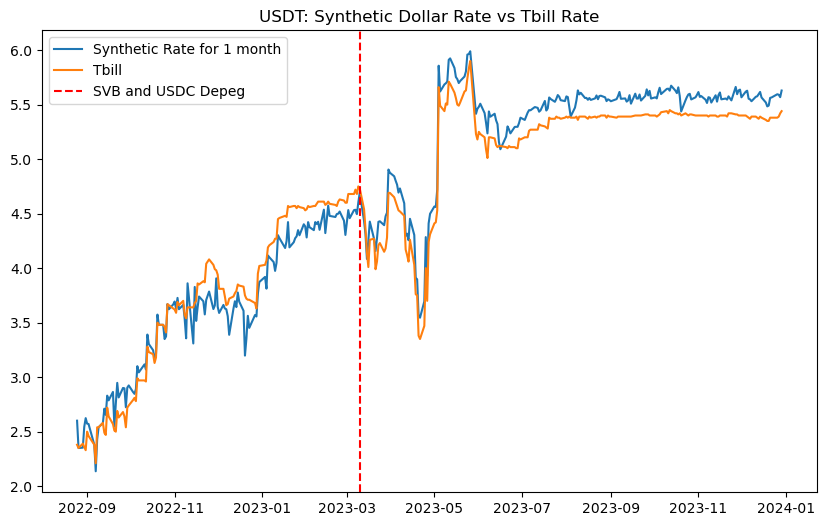

-0.07452660179996164
count    33700.000000
mean        -7.452660
std         17.080805
min        -29.566924
25%        -19.530948
50%        -15.561780
75%          3.696470
max         55.235171
Name: difference_1_month, dtype: float64
Index(['datetime', 'Tbill_1_month', 'Tbill_2_month', 'Tbill_3_month'], dtype='object')


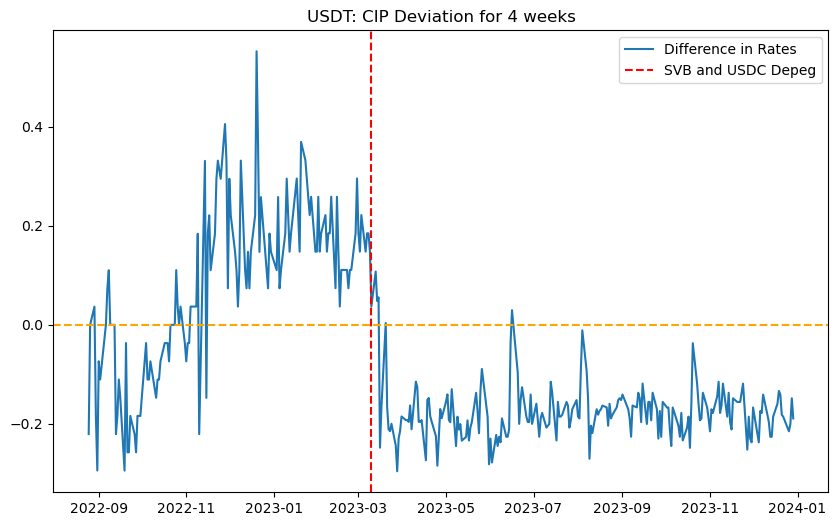

-0.07454432693483581
count    33700.000000
mean        -7.454433
std         17.088502
min        -29.576534
25%        -19.611437
50%        -15.564301
75%          3.697870
max         55.287597
Name: difference_2_month, dtype: float64
Index(['datetime', 'Tbill_1_month', 'Tbill_2_month', 'Tbill_3_month'], dtype='object')


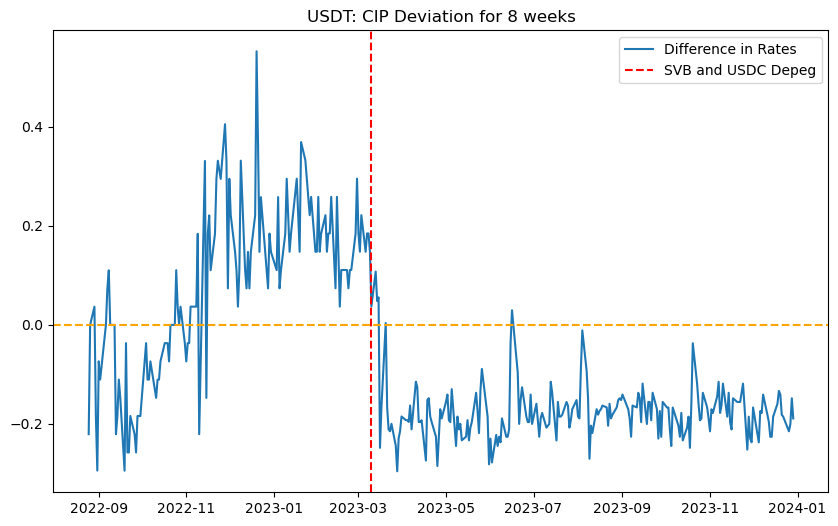

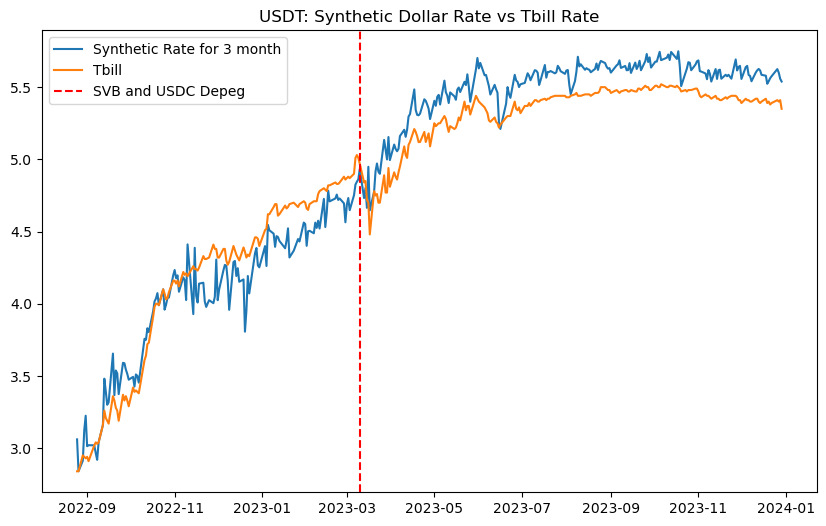

-0.07455922161190726
count    33700.000000
mean        -7.455922
std         17.094859
min        -29.614176
25%        -19.618864
50%        -15.565141
75%          3.698570
max         55.326543
Name: difference_3_month, dtype: float64


In [36]:
df1 = plot_tbills_cip(usdt_basis_df, interest_df, 'USDT', 1)
df2 = plot_tbills_cip(usdt_basis_df, interest_df, 'USDT', 2)
df3 = plot_tbills_cip(usdt_basis_df, interest_df, 'USDT', 3)


Index(['datetime', 'Tbill_1_month', 'Tbill_2_month', 'Tbill_3_month'], dtype='object')


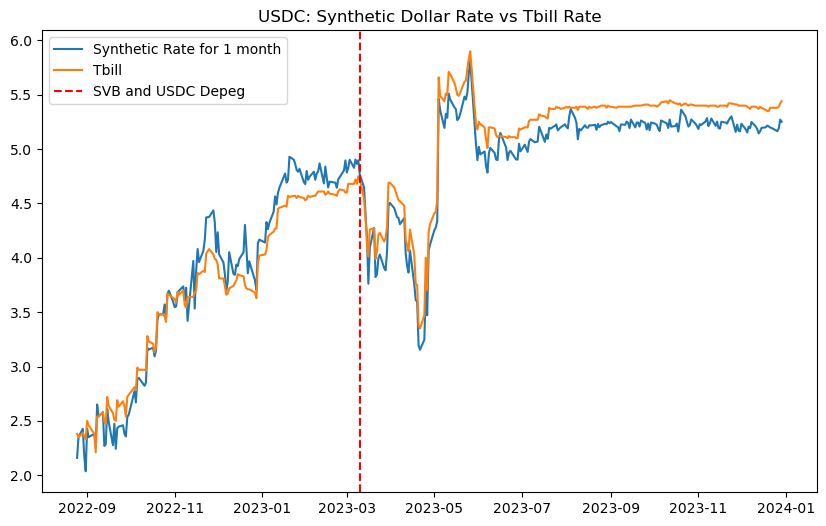

0.07443288719621223
count    33700.000000
mean         7.443289
std         17.082386
min        -55.318032
25%         -3.696839
50%         15.555244
75%         19.520598
max         29.543263
Name: difference_1_month, dtype: float64
Index(['datetime', 'Tbill_1_month', 'Tbill_2_month', 'Tbill_3_month'], dtype='object')


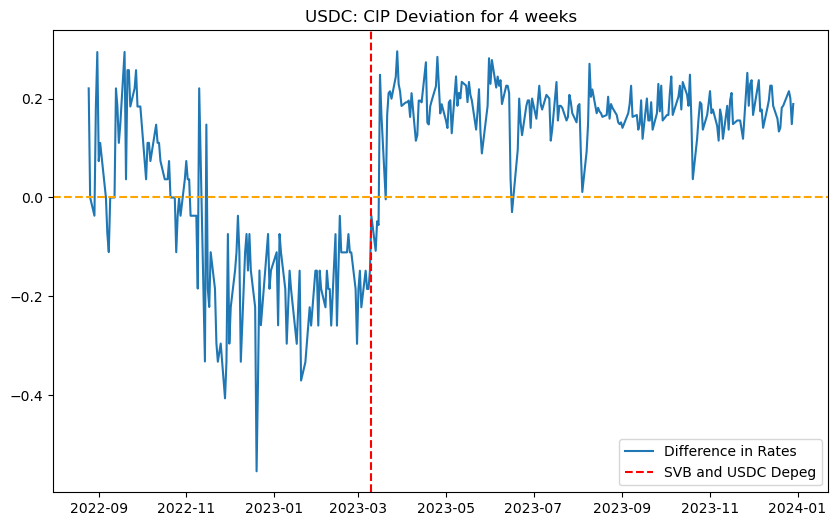

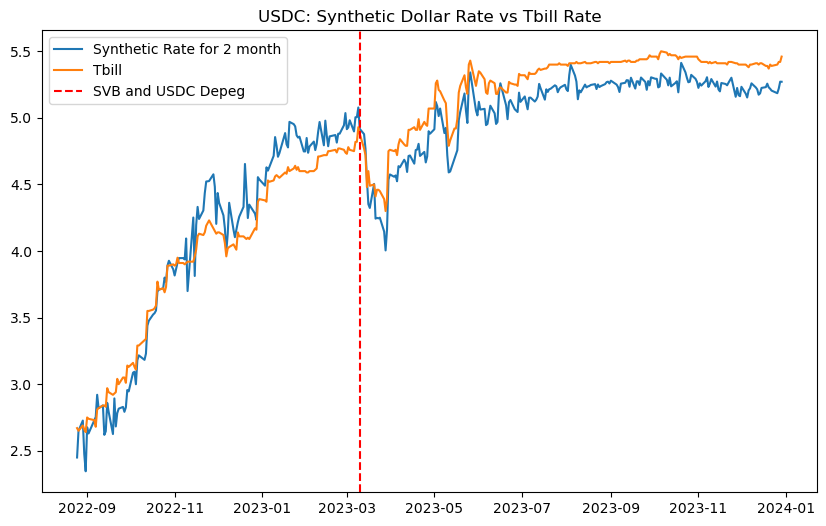

0.07445057321271041
count    33700.000000
mean         7.445057
std         17.090085
min        -55.370537
25%         -3.698240
50%         15.557764
75%         19.601040
max         29.552866
Name: difference_2_month, dtype: float64
Index(['datetime', 'Tbill_1_month', 'Tbill_2_month', 'Tbill_3_month'], dtype='object')


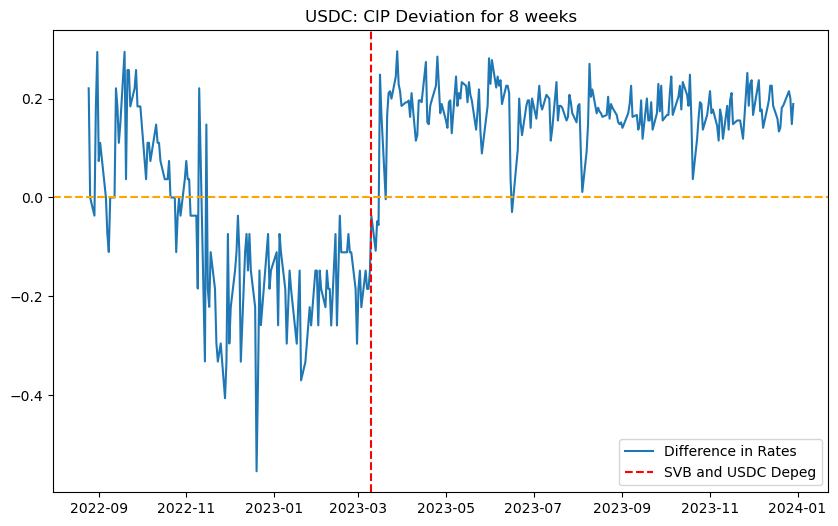

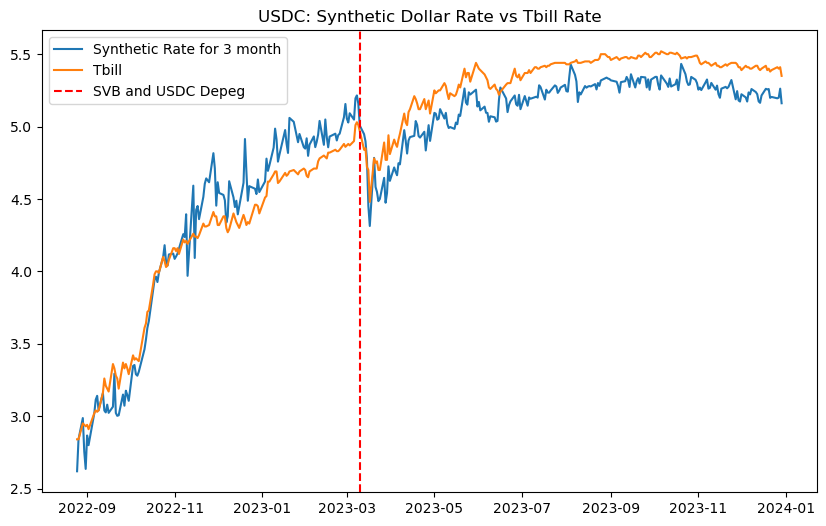

0.07446543555728126
count    33700.000000
mean         7.446544
std         17.096444
min        -55.409541
25%         -3.698940
50%         15.558604
75%         19.608463
max         29.590477
Name: difference_3_month, dtype: float64


Unnamed: 0   datetime  fundingRate  price_spot   volume_spot  \
0             0 2022-08-25     0.001095      0.9999  3.059998e+06   
1             1 2022-08-26     0.001095      1.0000  3.969963e+06   
2             5 2022-08-29     0.001095      0.9999  3.282521e+06   
3             6 2022-08-30     0.001095      1.0000  4.145159e+06   
4             7 2022-08-31     0.001095      0.9999  3.193600e+06   
..          ...        ...          ...         ...           ...   
332         487 2023-12-22     9.031560      0.9993  5.359146e+08   
333         491 2023-12-26    -6.271065      1.0001  4.770427e+08   
334         492 2023-12-27    -4.778215      0.9993  6.937438e+08   
335         493 2023-12-28     4.737335      0.9996  6.160015e+08   
336         494 2023-12-29     1.926470      0.9998  5.844738e+08   

     price_perps  volume_perps  trades_perps  Tbill_1_month  Tbill_2_month  \
0        0.99930     4336909.1           NaN           2.38           2.67   
1        1.00000      469168.0           NaN           2.35           2.65   
2        1.00000       22891.3           NaN           2.39           2.69   
3        0.99950     4246037.1           NaN           2.36           2.66   
4        0.99910     5569590.1           NaN           2.33           2.64   
..           ...           ...           ...            ...            ...   
332      0.99880     1127680.0        7656.0           5.38           5.39   
333      0.99952     2271332.0       13980.0           5.38           5.40   
334      0.99876     3041368.0       12968.0           5.39           5.42   
335      0.99920     2969099.0        9309.0           5.42           5.42   
336      0.99929     1861968.0        9858.0           5.44           5.46   

     Tbill_3_month      usdc_cip  synthetic_rate_3_month  difference_3_month  
0             2.84 -2.207261e-01                2.619274        2.207261e-01  
1             2.84 -2.309264e-14                2.840000        2.309264e-14  
2             2.95  3.679868e-02                2.986799       -3.679868e-02  
3             2.94 -1.839700e-01                2.756030        1.839700e-01  
4             2.93 -2.943734e-01                2.635627        2.943734e-01  
..             ...           ...                     ...                 ...  
332           5.39 -1.853247e-01                5.204675        1.853247e-01  
333           5.41 -2.148163e-01                5.195184        2.148163e-01  
334           5.40 -2.001561e-01                5.199844        2.001561e-01  
335           5.41 -1.482233e-01                5.261777        1.482233e-01  
336           5.35 -1.889163e-01                5.161084        1.889163e-01  

[337 rows x 14 columns]

In [37]:
plot_tbills_cip(usdc_basis_df, interest_df, 'USDC', 1)
plot_tbills_cip(usdc_basis_df, interest_df, 'USDC', 2)
plot_tbills_cip(usdc_basis_df, interest_df, 'USDC', 3)

Index(['datetime', 'Tbill_1_month', 'Tbill_2_month', 'Tbill_3_month'], dtype='object')


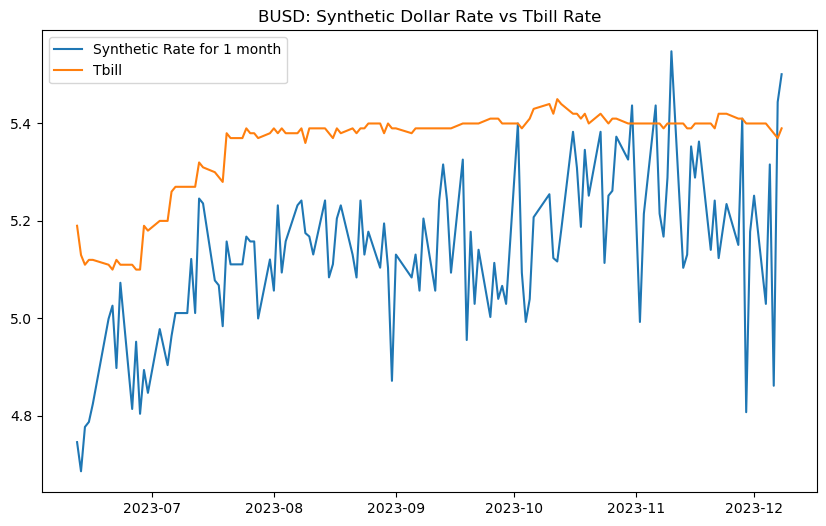

0.22334677795134095
count    12700.000000
mean        22.334678
std         12.750203
min        -14.824895
25%         14.812459
50%         22.230069
75%         29.623556
max         59.275855
Name: difference_1_month, dtype: float64
Index(['datetime', 'Tbill_1_month', 'Tbill_2_month', 'Tbill_3_month'], dtype='object')


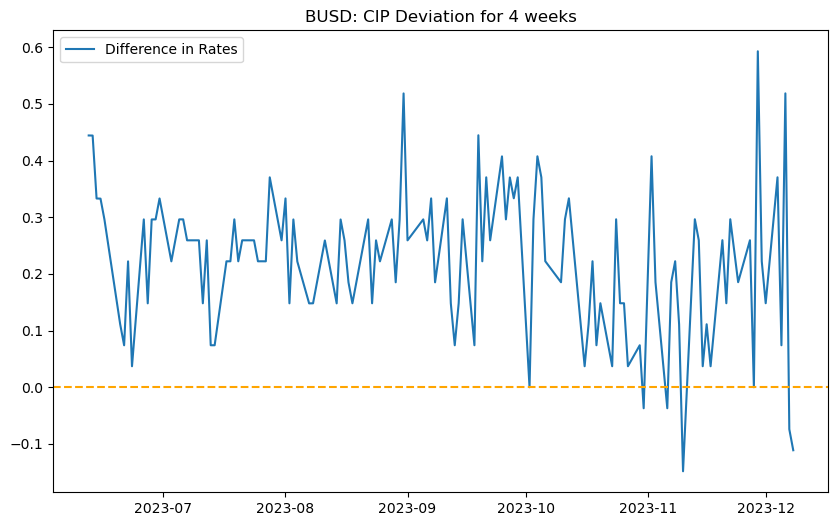

0.22337352292840573
count    12700.000000
mean        22.337352
std         12.751490
min        -14.825295
25%         14.814259
50%         22.231269
75%         29.629556
max         59.275855
Name: difference_2_month, dtype: float64
Index(['datetime', 'Tbill_1_month', 'Tbill_2_month', 'Tbill_3_month'], dtype='object')


0.22339793668318525
count    12700.000000
mean        22.339794
std         12.752815
min        -14.825695
25%         14.816682
50%         22.234447
75%         29.635600
max         59.277455
Name: difference_3_month, dtype: float64


Unnamed: 0   datetime  fundingRate  price_spot   volume_spot  \
0             2 2023-06-12   -21.742320      1.0000  2.137170e+07   
1             3 2023-06-13   -33.952665      1.0002  2.169975e+07   
2             4 2023-06-14    -9.996985      1.0002  2.092540e+07   
3             5 2023-06-15     2.486745      1.0010  6.596932e+07   
4             6 2023-06-16    -1.284435      1.0006  1.771574e+07   
..          ...        ...          ...         ...           ...   
122         179 2023-12-04    -1.178585      1.0000  2.037641e+08   
123         180 2023-12-05     9.267715      0.9998  8.015907e+07   
124         181 2023-12-06    10.950000      1.0001  9.550173e+07   
125         182 2023-12-07    10.950000      0.9998  7.952453e+07   
126         183 2023-12-08     7.300000      0.9997  5.438316e+07   

     price_perps  volume_perps  Tbill_1_month  Tbill_2_month  Tbill_3_month  \
0         0.9988      500109.6           5.19           5.26           5.29   
1         0.9990       93810.3           5.13           5.18           5.26   
2         0.9993      452447.8           5.11           5.18           5.25   
3         1.0001      616115.1           5.12           5.22           5.22   
4         0.9998      179459.0           5.12           5.23           5.24   
..           ...           ...            ...            ...            ...   
122       0.9990      112010.6           5.40           5.40           5.42   
123       0.9996       89144.3           5.39           5.39           5.41   
124       0.9987       32737.4           5.38           5.38           5.41   
125       1.0000       64204.7           5.37           5.40           5.40   
126       1.0000       23600.0           5.39           5.40           5.40   

     busd_cip  synthetic_rate_3_month  difference_3_month  
0   -0.444348                4.845652            0.444348  
1   -0.444223                4.815777            0.444223  
2   -0.333158                4.916842            0.333158  
3   -0.332865                4.887135            0.332865  
4   -0.296014                4.943986            0.296014  
..        ...                     ...                 ...  
122 -0.370420                5.049580            0.370420  
123 -0.074097                5.335903            0.074097  
124 -0.518522                4.891478            0.518522  
125  0.074095                5.474095           -0.074095  
126  0.111153                5.511153           -0.111153  

[127 rows x 13 columns]

In [38]:
plot_tbills_cip(busd_basis_df, interest_df, 'BUSD', 1)
plot_tbills_cip(busd_basis_df, interest_df, 'BUSD', 2)
plot_tbills_cip(busd_basis_df, interest_df, 'BUSD', 3)

# Data Consolidation for Testing

In [39]:
asset_dict = {'USDT': [defi_usdt_overall_df, tbill_overall_usdt_df],
 'USDC': [defi_usdc_overall_df, tbill_overall_usdc_df], 
              'BUSD': [defi_busd_overall_df,tbill_overall_busd_df ]
             }

In [40]:
stablecoins = ['USDT', 'USDC', 'BUSD']
for stablecoin in stablecoins:
  new_list = []
  list_dfs = asset_dict[stablecoin]
  for df in list_dfs:
    cols = list(circulating_supply.columns)
    for col in cols: 
        if stablecoin.lower() in col: 
            break 
    circulating_df = circulating_supply[['datetime', col]]
    df['datetime'] = (df['datetime']).astype(str)

    btc['datetime'] = pd.to_datetime(btc['datetime'])
    df['datetime'] = pd.to_datetime(df['datetime'])

    new_df = pd.merge(df, btc, on = 'datetime')


    new_df['crisis'] = ((new_df['datetime'] >= '2022-11-02') & (new_df['datetime'] <= '2022-11-12')) | ((new_df['datetime'] >= '2023-03-10') & (new_df['datetime'] <= '2023-03-18'))
    new_df['crisis']  = new_df['crisis'].astype(int)
    
    eth_gas = eth_gas[['datetime', 'eth_gas']]
    bsc_gas = bsc_gas[['datetime', 'bsc_gas']]
    
    
    new_df = pd.merge(new_df, eth_gas, on = 'datetime')
    new_df = pd.merge(new_df, bsc_gas, on = 'datetime')
    
    new_df = pd.merge(new_df, circulating_df, on = 'datetime')
    
     
        
    new_list.append(new_df)

  asset_dict[stablecoin] = new_list

# CIP vs Gas Cost (Transaction Frictions) 

In [41]:
def plot_deviations_gas(df, asset):
    scaler = MinMaxScaler()
    
    if 'eth_gas' in df.columns: 
        gas_col = 'eth_gas'
    elif 'bsc_gas' in df.columns: 
        gas_col = 'bsc_gas'
    df[[gas_col, f'{asset}_cip']] = scaler.fit_transform(df[[gas_col, f'{asset}_cip']])
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Datetime')
    ax1.set_ylabel('Gas', color=color)

    ax1.plot(df[gas_col], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(f'{asset} CIP', color=color)
    ax2.plot(df[f'{asset}_cip'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.title(f"Overall CIP Deviation for {asset}")

    plt.show()

    print(df[[gas_col, f'{asset}_cip']].corr())

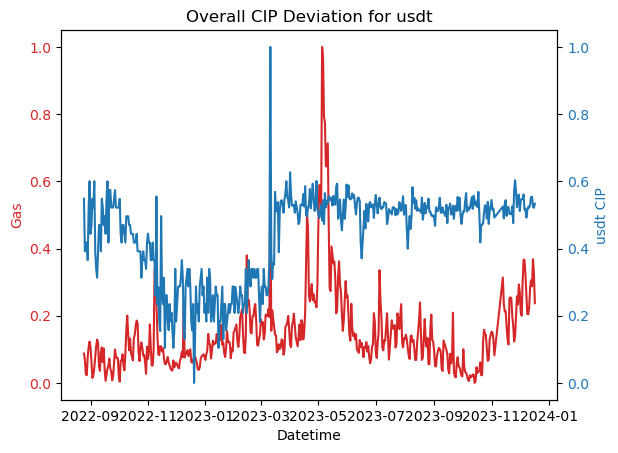

           eth_gas  usdt_cip
eth_gas   1.000000  0.217524
usdt_cip  0.217524  1.000000
[0.22821966 0.40649612]


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=df, palette='viridis')


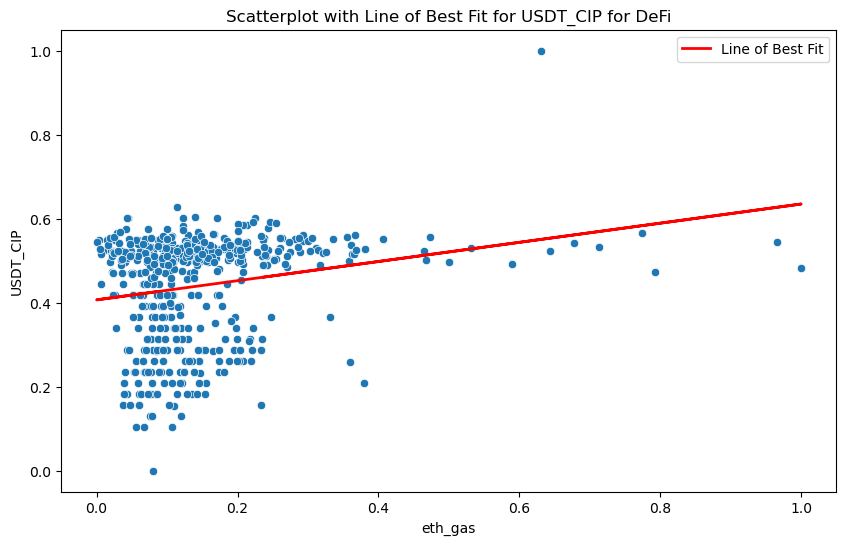

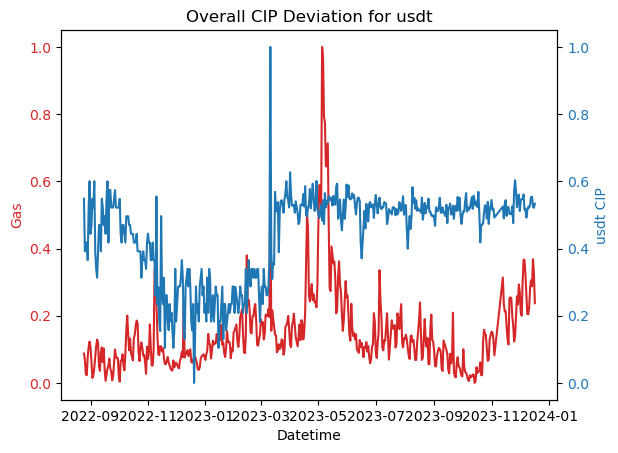

           eth_gas  usdt_cip
eth_gas   1.000000  0.217524
usdt_cip  0.217524  1.000000
[-0.37370488  0.36942242]


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_depeg['line_best_fit'] = line_best_fit
/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:60: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=before_depeg, palette='viridis')


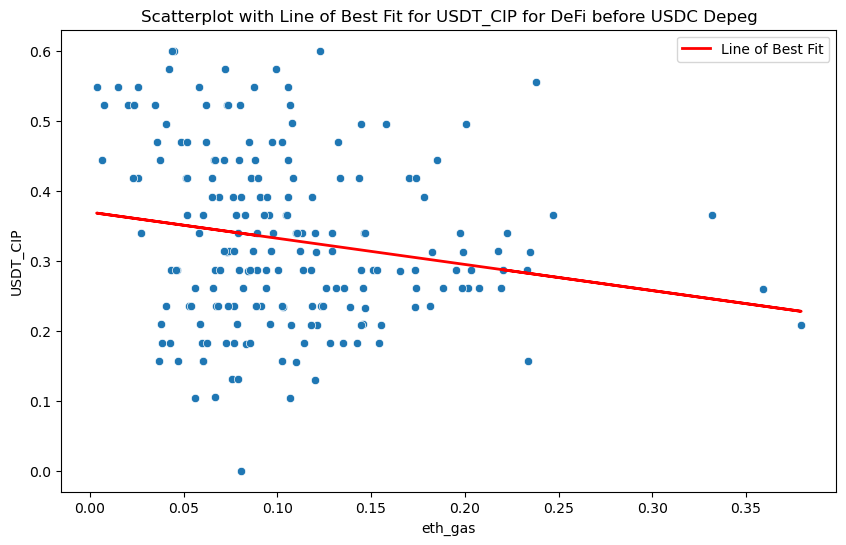

[0.05725368 0.51046173]


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_depeg['line_best_fit'] = line_best_fit
/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:78: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=after_depeg, palette='viridis')


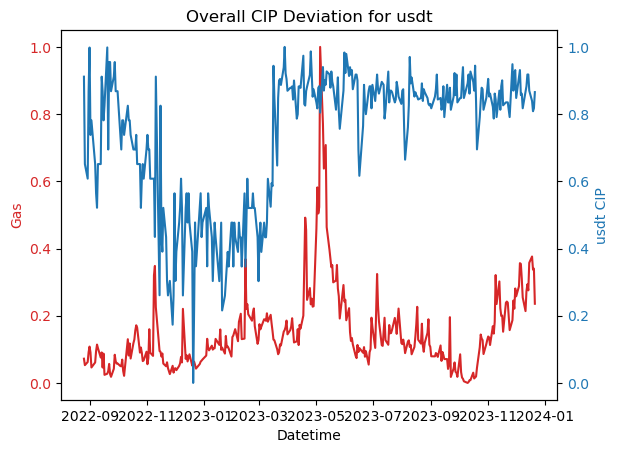

           eth_gas  usdt_cip
eth_gas   1.000000  0.210136
usdt_cip  0.210136  1.000000
[0.34200825 0.68459355]


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=df, palette='viridis')


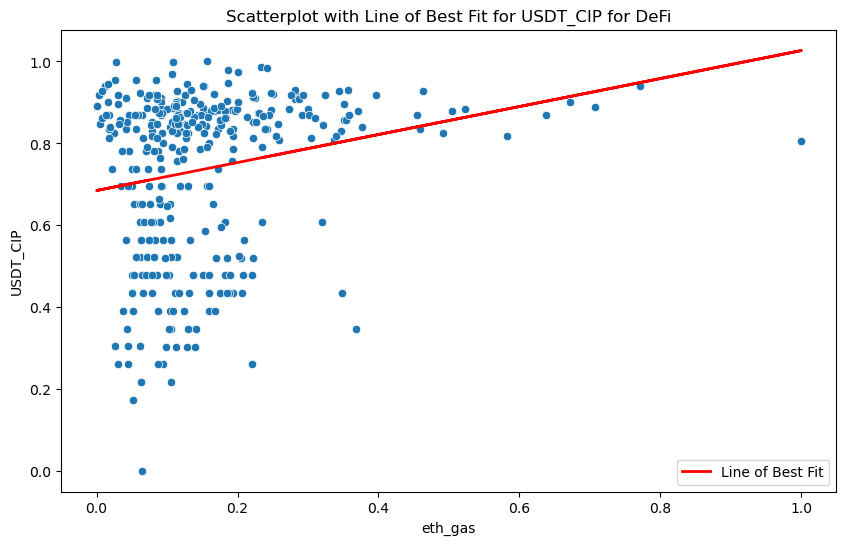

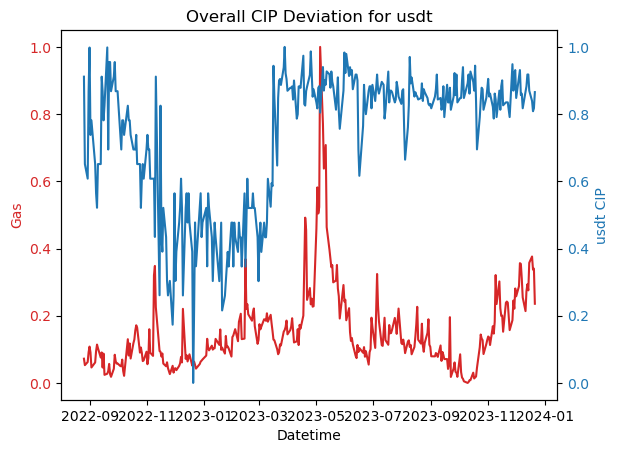

           eth_gas  usdt_cip
eth_gas   1.000000  0.210136
usdt_cip  0.210136  1.000000
[-0.63657982  0.62323548]


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_depeg['line_best_fit'] = line_best_fit
/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:60: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=before_depeg, palette='viridis')


[0.03650711 0.85151683]


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_depeg['line_best_fit'] = line_best_fit
/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:78: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=after_depeg, palette='viridis')


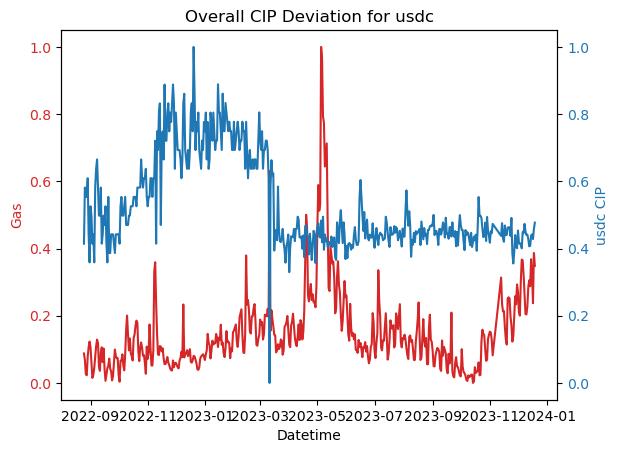

           eth_gas  usdc_cip
eth_gas   1.000000 -0.216411
usdc_cip -0.216411  1.000000
[-0.23832196  0.56378617]


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=df, palette='viridis')


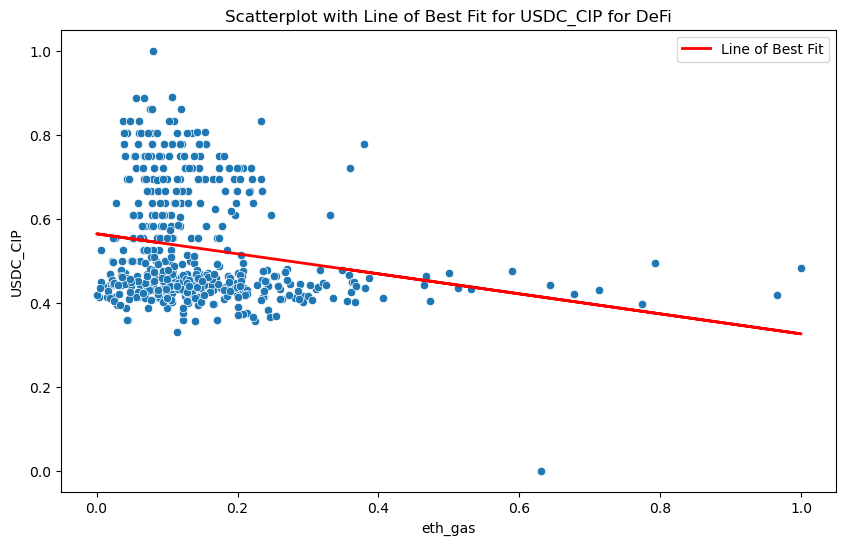

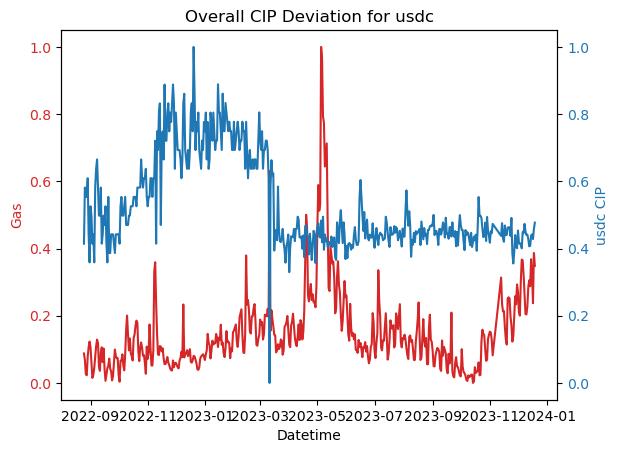

           eth_gas  usdc_cip
eth_gas   1.000000 -0.216411
usdc_cip -0.216411  1.000000
[0.39975936 0.60509739]


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_depeg['line_best_fit'] = line_best_fit
/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:60: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=before_depeg, palette='viridis')


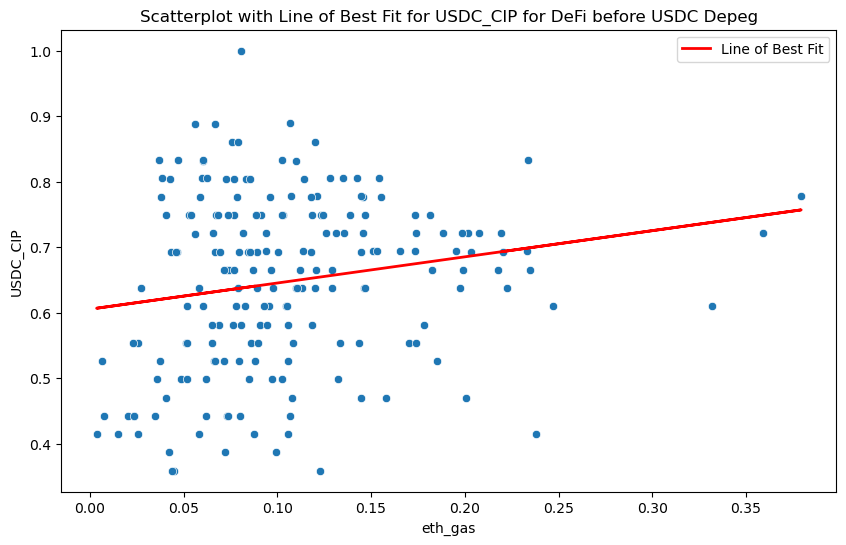

[-0.05323529  0.45315359]


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_depeg['line_best_fit'] = line_best_fit
/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:78: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=after_depeg, palette='viridis')


           eth_gas  usdc_cip
eth_gas   1.000000 -0.210118
usdc_cip -0.210118  1.000000
[-0.34177256  0.31501844]


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=df, palette='viridis')


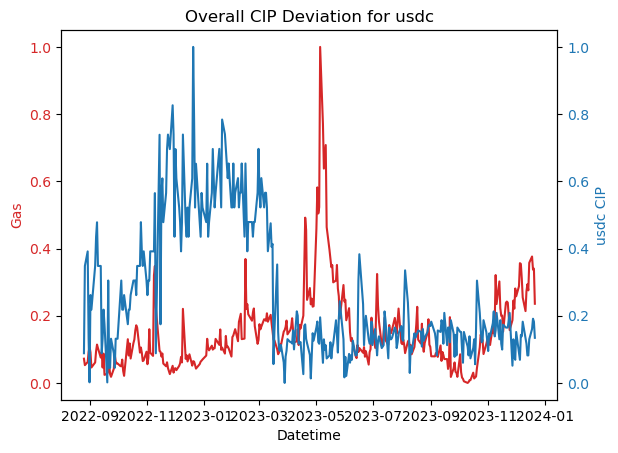

           eth_gas  usdc_cip
eth_gas   1.000000 -0.210118
usdc_cip -0.210118  1.000000
[0.63597206 0.37635299]


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_depeg['line_best_fit'] = line_best_fit
/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:60: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=before_depeg, palette='viridis')


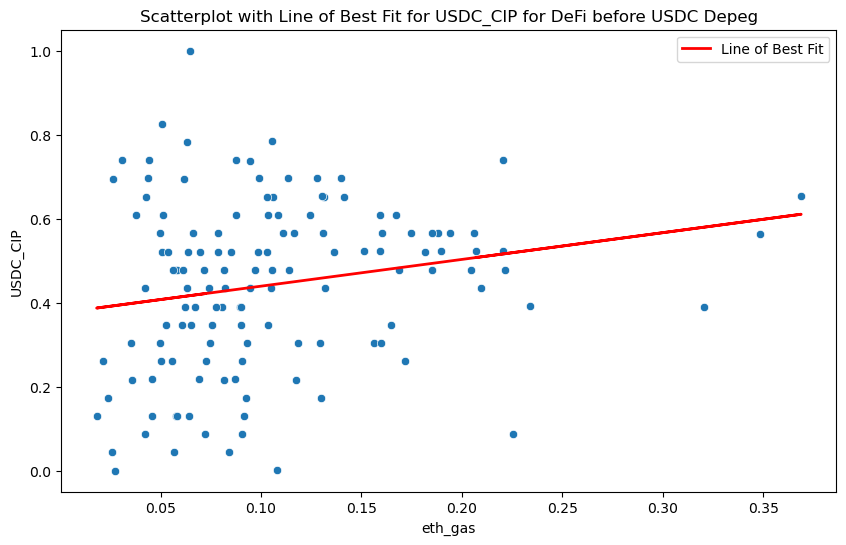

[-0.03645715  0.14820495]


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_depeg['line_best_fit'] = line_best_fit
/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:78: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=after_depeg, palette='viridis')


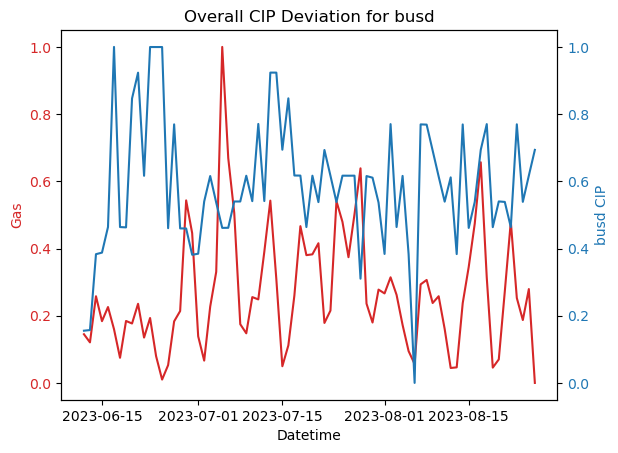

           eth_gas  busd_cip
eth_gas   1.000000 -0.097272
busd_cip -0.097272  1.000000
[-0.10277904  0.61410245]


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=df, palette='viridis')


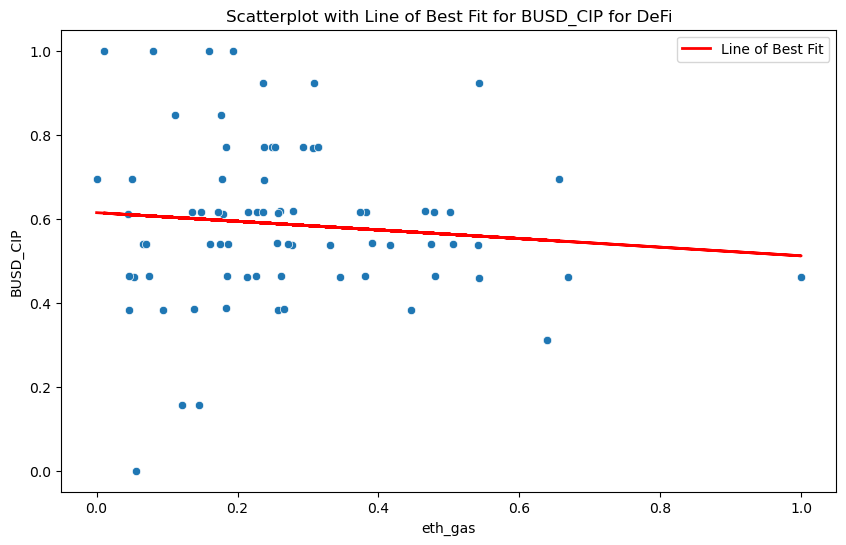

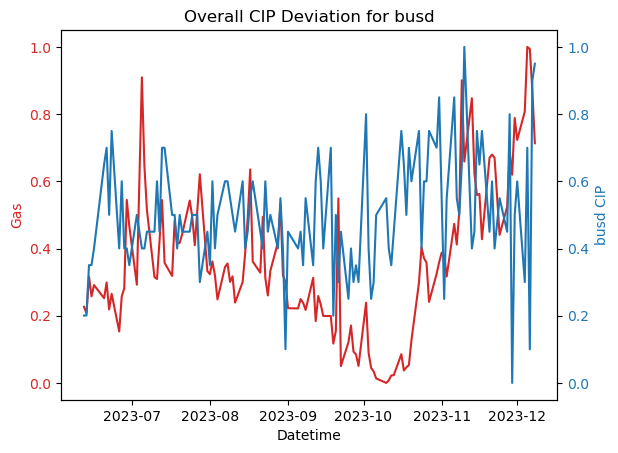

           eth_gas  busd_cip
eth_gas   1.000000  0.119871
busd_cip  0.119871  1.000000
[0.09214873 0.46464974]


/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/303405549.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=df, palette='viridis')


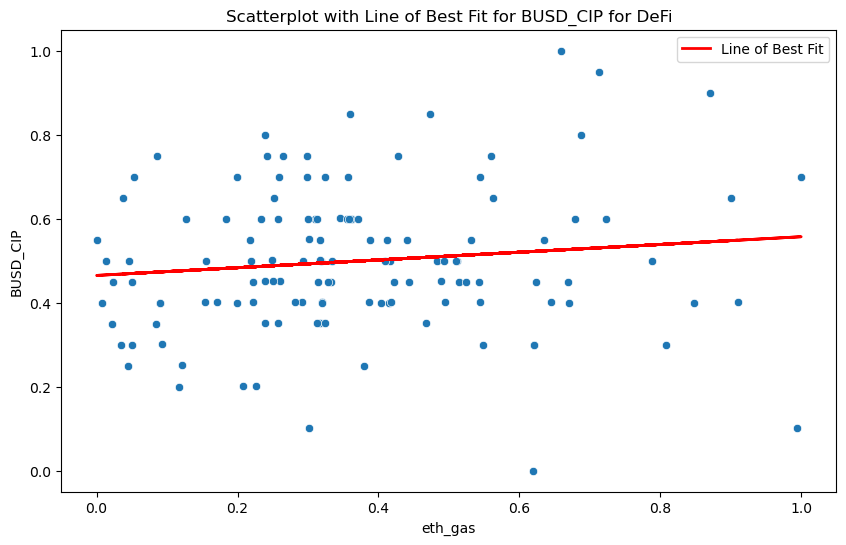

In [42]:
for stablecoin in stablecoins: 
    for i in range(len(asset_dict[stablecoin])):
        asset = stablecoin
        overall_df = asset_dict[stablecoin][i]
        if 'eth_gas' in overall_df.columns: 
            gas_col = 'eth_gas'
        elif 'bsc_gas' in overall_df.columns: 
            gas_col = 'bsc_gas'
        columns = list(overall_df.columns)
        overall_df[gas_col] = overall_df[gas_col]/10**18

        if 'Tbill' in columns:
            type_comparison = 'CeFi'
            df = overall_df[['datetime', f'{asset.lower()}_cip', 'vol_btc', gas_col, 'crisis']].set_index('datetime')

        else:
            type_comparison = 'DeFi'
            df = overall_df[['datetime',  f'{asset.lower()}_cip','vol_btc', gas_col, 'crisis']].set_index('datetime')
          
        plot_deviations_gas(df, asset.lower())
        
        X = df[[ gas_col]]
        y = df[f'{asset.lower()}_cip']
        coefficients = np.polyfit(X[gas_col], y, 1)
        print(coefficients)
        line_best_fit = np.polyval(coefficients, X[gas_col])

        df['line_best_fit'] = line_best_fit

        plt.figure(figsize=(10, 6))
        scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=df, palette='viridis')
        plt.plot(X[gas_col], line_best_fit, color='red', linewidth=2, label='Line of Best Fit')
        plt.title(f'Scatterplot with Line of Best Fit for {asset.upper()}_CIP for {type_comparison}')
        plt.xlabel(gas_col)
        plt.ylabel(f'{asset.upper()}_CIP')
        plt.legend()
        plt.show()
        
        
        # was there a change post usdc depeg? 
        
        if asset == 'BUSD': 
            continue
       
        
        before_depeg = df.loc[df.index < usdc_depeg_date]
        after_depeg = df.loc[df.index >= usdc_depeg_date]
                             
        plot_deviations_gas(df, asset.lower())
        
        X = before_depeg[[ gas_col]]
        y = before_depeg[f'{asset.lower()}_cip']
        coefficients = np.polyfit(X[gas_col], y, 1)
        print(coefficients)
        line_best_fit = np.polyval(coefficients, X[gas_col])

        before_depeg['line_best_fit'] = line_best_fit

        plt.figure(figsize=(10, 6))
        scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=before_depeg, palette='viridis')
        plt.plot(X[gas_col], line_best_fit, color='red', linewidth=2, label='Line of Best Fit')
        plt.title(f'Scatterplot with Line of Best Fit for {asset.upper()}_CIP for {type_comparison} before USDC Depeg')
        plt.xlabel(gas_col)
        plt.ylabel(f'{asset.upper()}_CIP')
        plt.legend()
        plt.show()
                             
                             
        X = after_depeg[[ gas_col]]
        y = after_depeg[f'{asset.lower()}_cip']
        coefficients = np.polyfit(X[gas_col], y, 1)
        print(coefficients)
        line_best_fit = np.polyval(coefficients, X[gas_col])

        after_depeg['line_best_fit'] = line_best_fit

        plt.figure(figsize=(10, 6))
        scatterplot = sns.scatterplot(x=gas_col, y=f'{asset.lower()}_cip', data=after_depeg, palette='viridis')
        plt.plot(X[gas_col], line_best_fit, color='red', linewidth=2, label='Line of Best Fit')
        plt.title(f'Scatterplot with Line of Best Fit for {asset.upper()}_CIP for {type_comparison} after USDC Depeg ')
        plt.xlabel(gas_col)
        plt.ylabel(f'{asset.upper()}_CIP')
        plt.legend()
        plt.show()
        
        

            


In [43]:
asset_dict['BUSD'][1]['busd_cip'].mean()

-0.22334677795134095

# CIP vs Volume (Liquidity Profile) 

In [44]:
for stablecoin in stablecoins: 
    for i in range(len(asset_dict[stablecoin])):
        asset = stablecoin
        overall_df = asset_dict[stablecoin][i]
        columns = list(overall_df.columns)

        if 'Tbill' in columns:
            type_comparison = 'CeFi'
            df = overall_df[['datetime', f'{asset.lower()}_cip', 'vol_btc', 'volume_perps', 'volume_spot']].set_index('datetime')

        else:
            type_comparison = 'DeFi'
            df = overall_df[['datetime',  f'{asset.lower()}_cip','vol_btc', 'volume_perps', 'volume_spot']].set_index('datetime')
          
        
        volume = df['volume_perps'] + df['volume_spot']
        X = volume
        y = df[f'{asset.lower()}_cip']
        coefficients = np.polyfit(volume, y, 1)
        line_best_fit = np.polyval(coefficients, volume)

        df['line_best_fit'] = line_best_fit

#         plt.figure(figsize=(10, 6))
#         scatterplot = sns.scatterplot(x='volume_perps', y=f'{asset.lower()}_cip', data=df, palette='viridis')
#         plt.plot(X['volume_perps'], line_best_fit, color='red', linewidth=2, label='Line of Best Fit')
#         plt.title(f'Scatterplot with Line of Best Fit for {asset.upper()}_CIP for {type_comparison}')
#         plt.xlabel('volume_perps')
#         plt.ylabel(f'{asset.upper()}_CIP')
#         plt.legend()
#         plt.show()
        print(np.log(df[['volume_perps',f'{asset.lower()}_cip']]).corr())

              volume_perps  usdt_cip
volume_perps      1.000000  0.003943
usdt_cip          0.003943  1.000000
              volume_perps  usdt_cip
volume_perps      1.000000  0.188372
usdt_cip          0.188372  1.000000
              volume_perps  usdc_cip
volume_perps      1.000000 -0.119407
usdc_cip         -0.119407  1.000000
              volume_perps  usdc_cip
volume_perps      1.000000 -0.066575
usdc_cip         -0.066575  1.000000
              volume_perps  busd_cip
volume_perps           1.0       NaN
busd_cip               NaN       NaN
              volume_perps  busd_cip
volume_perps      1.000000 -0.136524
busd_cip         -0.136524  1.000000


/Users/patsy/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Users/patsy/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Users/patsy/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Users/patsy/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Users/patsy/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Users/patsy/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid va

In [45]:
data = asset_dict['USDT'][0]
data['volume'] = (data['volume_perps'] + data['volume_spot'])
dates = pd.date_range(start="2023-01-01", periods=100)
data['cip_change'] = data['usdt_cip'].diff()
data['volume_change'] = data['volume'].diff()


In [46]:
depeg_date =  '2023-03-10'
data['period'] = (data['datetime'] >= depeg_date).astype(int)
X = data[['volume', 'period']]
y = data['usdt_cip']

model = sm.OLS(y, X).fit()
print(model.summary())


                                 OLS Regression Results                                
Dep. Variable:               usdt_cip   R-squared (uncentered):                   0.506
Model:                            OLS   Adj. R-squared (uncentered):              0.503
Method:                 Least Squares   F-statistic:                              237.7
Date:                Fri, 26 Apr 2024   Prob (F-statistic):                    7.61e-72
Time:                        17:38:33   Log-Likelihood:                          267.52
No. Observations:                 467   AIC:                                     -531.0
Df Residuals:                     465   BIC:                                     -522.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<Figure size 1000x600 with 0 Axes>

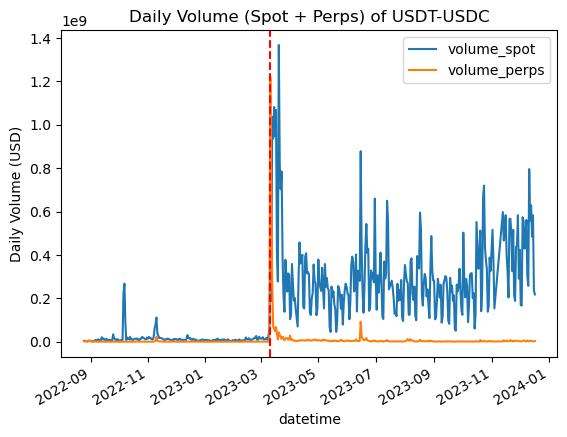

In [47]:
plt.figure(figsize=(10,6)) 
asset_dict['USDT'][0][['datetime', 'volume_spot', 'volume_perps']].set_index('datetime').plot()
plt.ylabel('Daily Volume (USD)')
plt.axvline(x = pd.to_datetime('2023-03-11'), label = 'USDC Depeg: Binance Launch', color = 'r', linestyle = '--')
plt.title('Daily Volume (Spot + Perps) of USDT-USDC')
plt.show()

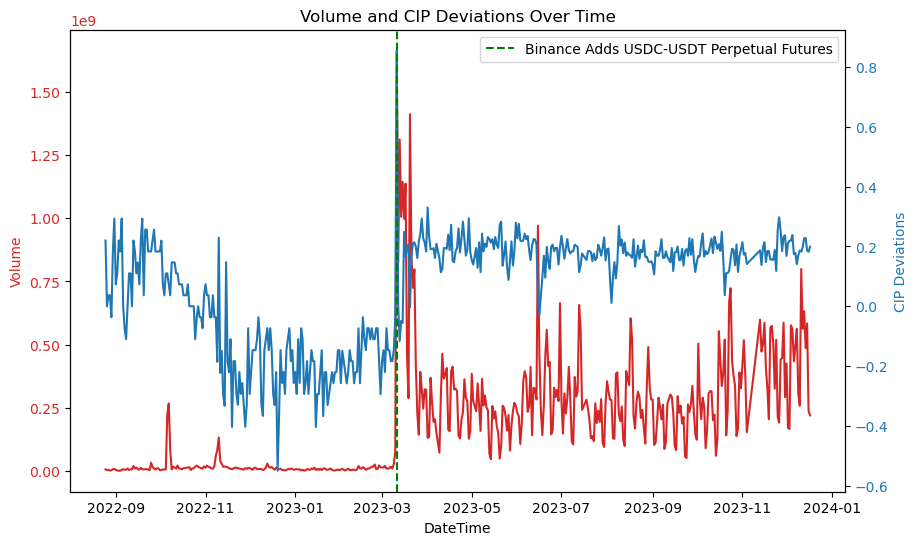

In [48]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('DateTime')
ax1.set_ylabel('Volume', color=color)
ax1.plot(data['datetime'], data['volume'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('CIP Deviations', color=color) 
ax2.plot(data['datetime'], data['usdt_cip'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.axvline(pd.Timestamp('2023-03-11'), color='green', linestyle='--', label='Binance Adds USDC-USDT Perpetual Futures')
plt.legend()
plt.title('Volume and CIP Deviations Over Time')
plt.show()

# CIP vs Event

In [49]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar import irf

In [50]:
new_df['crisis'] = ((new_df['datetime'] >= '2022-11-02') & (new_df['datetime'] <= '2022-11-12')) | ((new_df['datetime'] >= '2023-03-10') & (new_df['datetime'] <= '2023-03-18'))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['Unnamed: 0', 'datetime', 'fundingRate', 'price_spot', 'volume_spot', 'price_perps', 'volume_perps', 'trades_perps', 'Day', 'AAVE_USDT', 'usdt_cip', 'synthetic_rate', 'vol_btc', 'crisis', 'eth_gas', 'bsc_gas', 'usdt_circulatingsupply', 'volume', 'cip_change', 'volume_change', 'period']
False


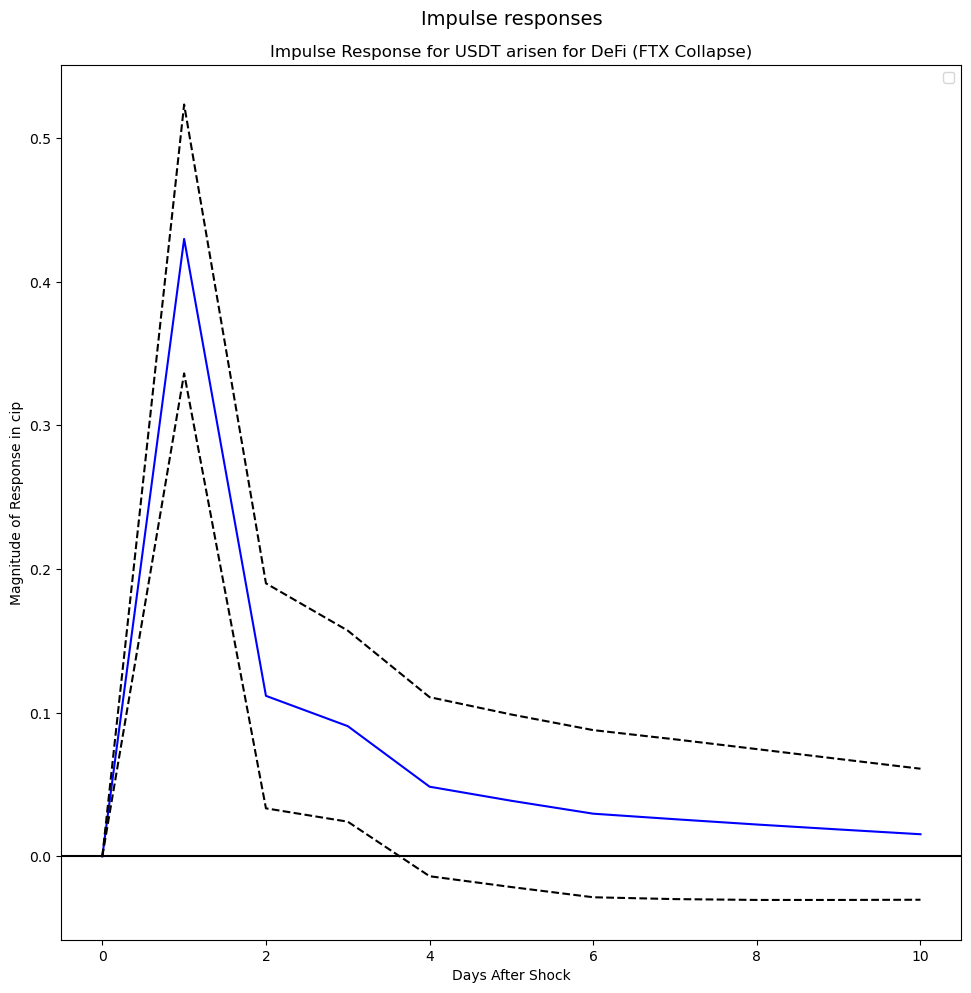

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


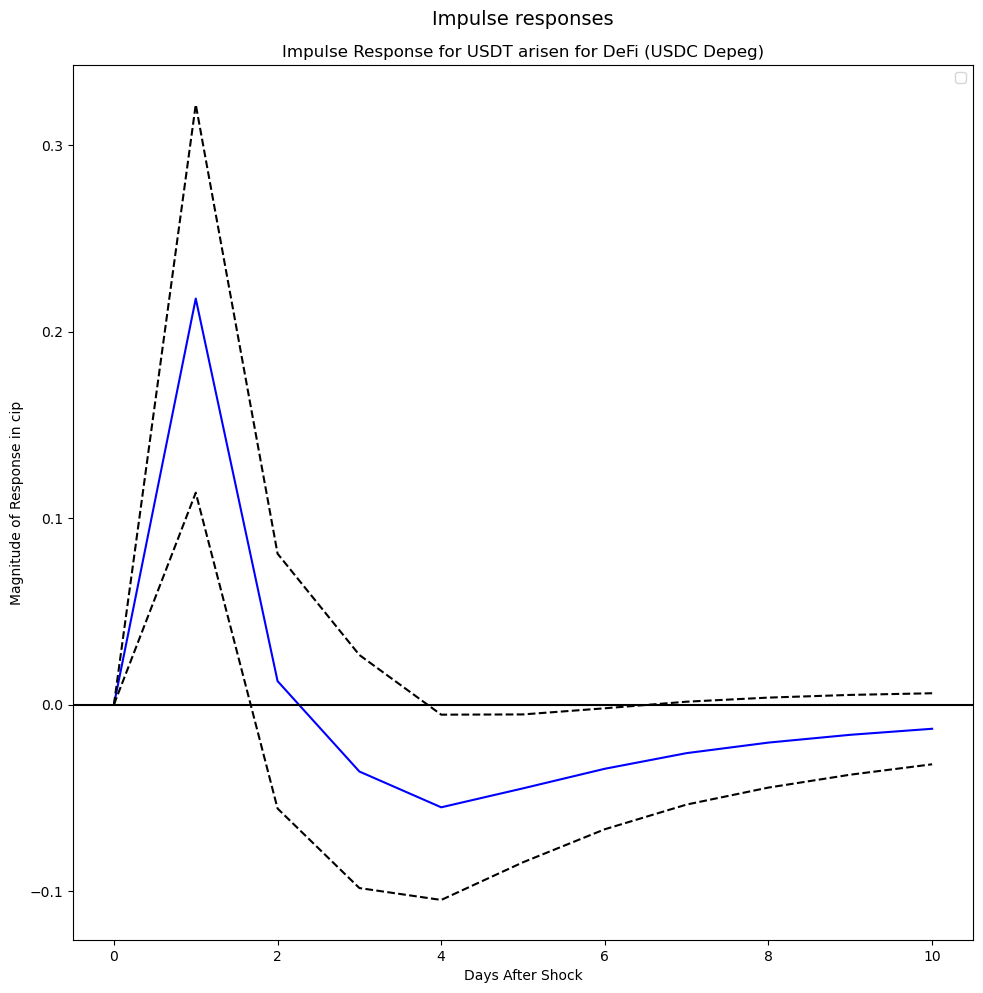

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['Unnamed: 0', 'datetime', 'fundingRate', 'price_spot', 'volume_spot', 'price_perps', 'volume_perps', 'trades_perps', 'Tbill_1_month', 'Tbill_2_month', 'Tbill_3_month', 'usdt_cip', 'synthetic_rate_1_month', 'difference_1_month', 'vol_btc', 'crisis', 'eth_gas', 'bsc_gas', 'usdt_circulatingsupply']
True


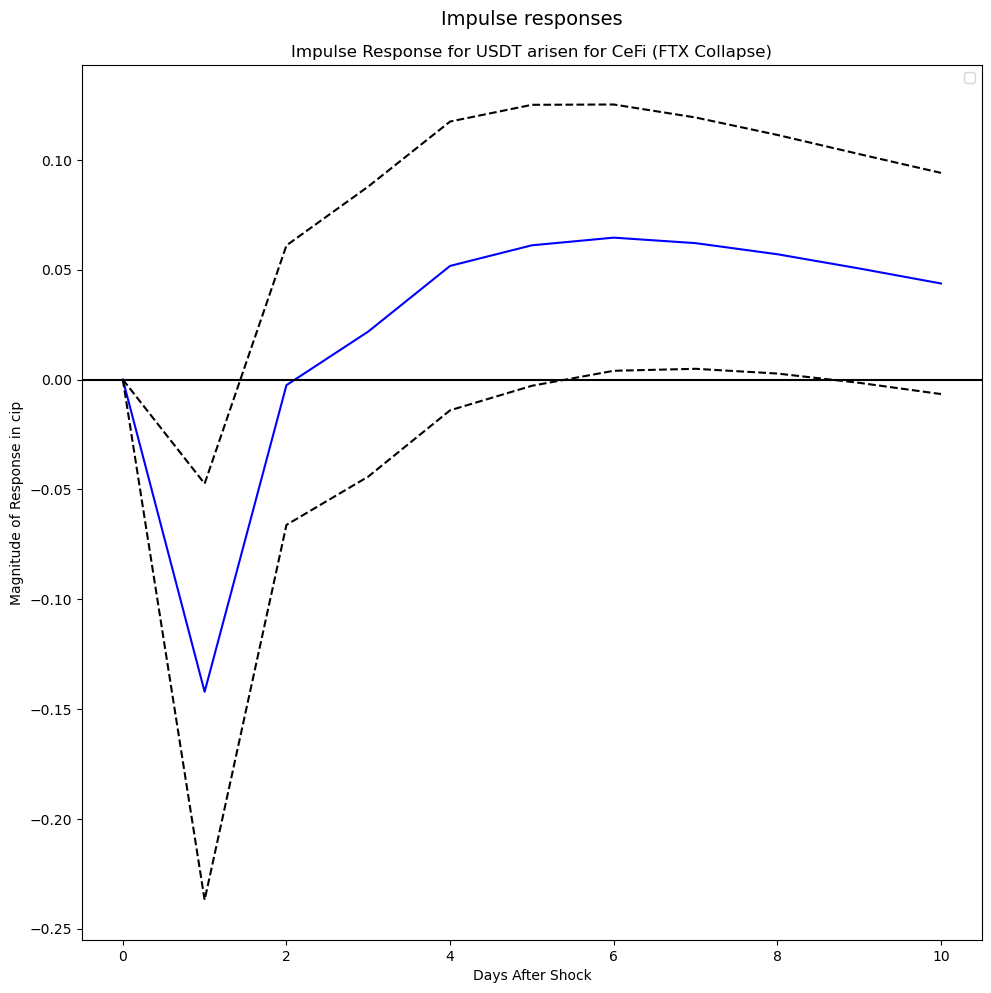

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


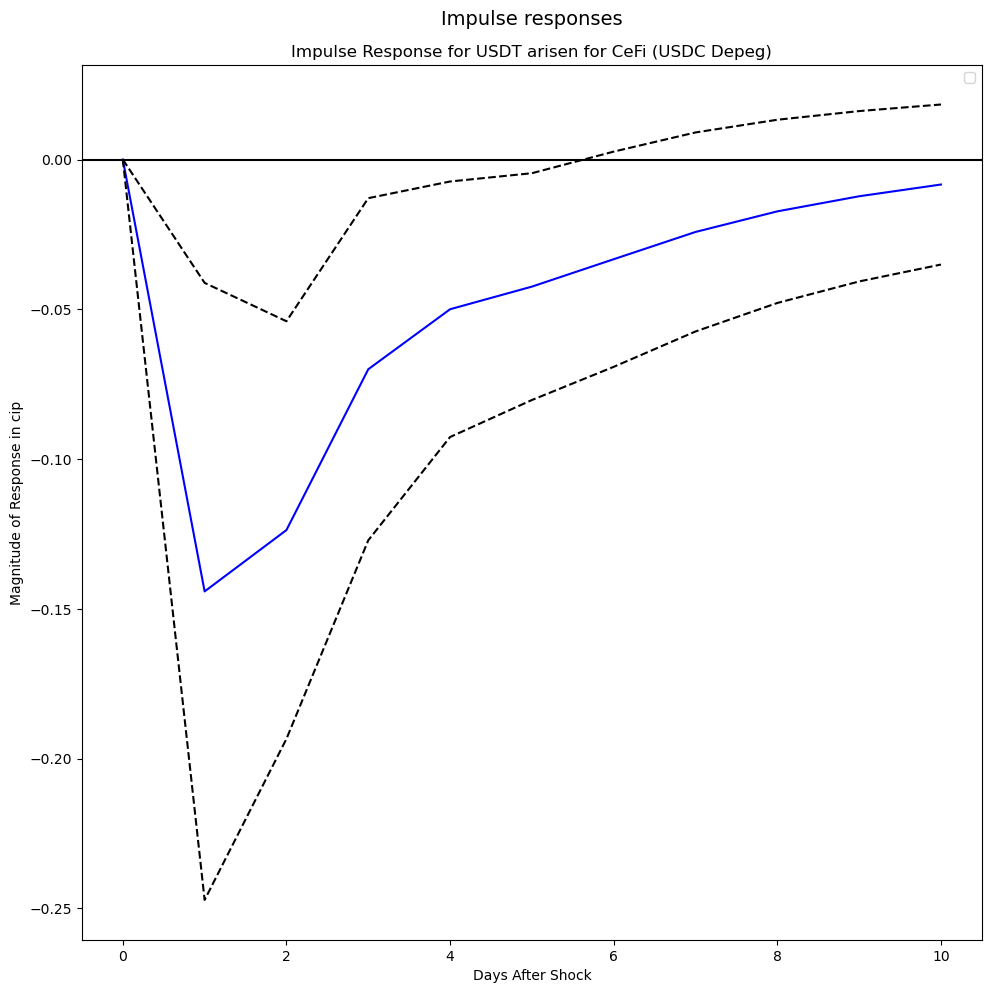

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['Unnamed: 0', 'datetime', 'fundingRate', 'price_spot', 'volume_spot', 'price_perps', 'volume_perps', 'trades_perps', 'Day', 'AAVE_USDC', 'usdc_cip', 'synthetic_rate', 'vol_btc', 'crisis', 'eth_gas', 'bsc_gas', 'usdc_circulatingsupply']
False


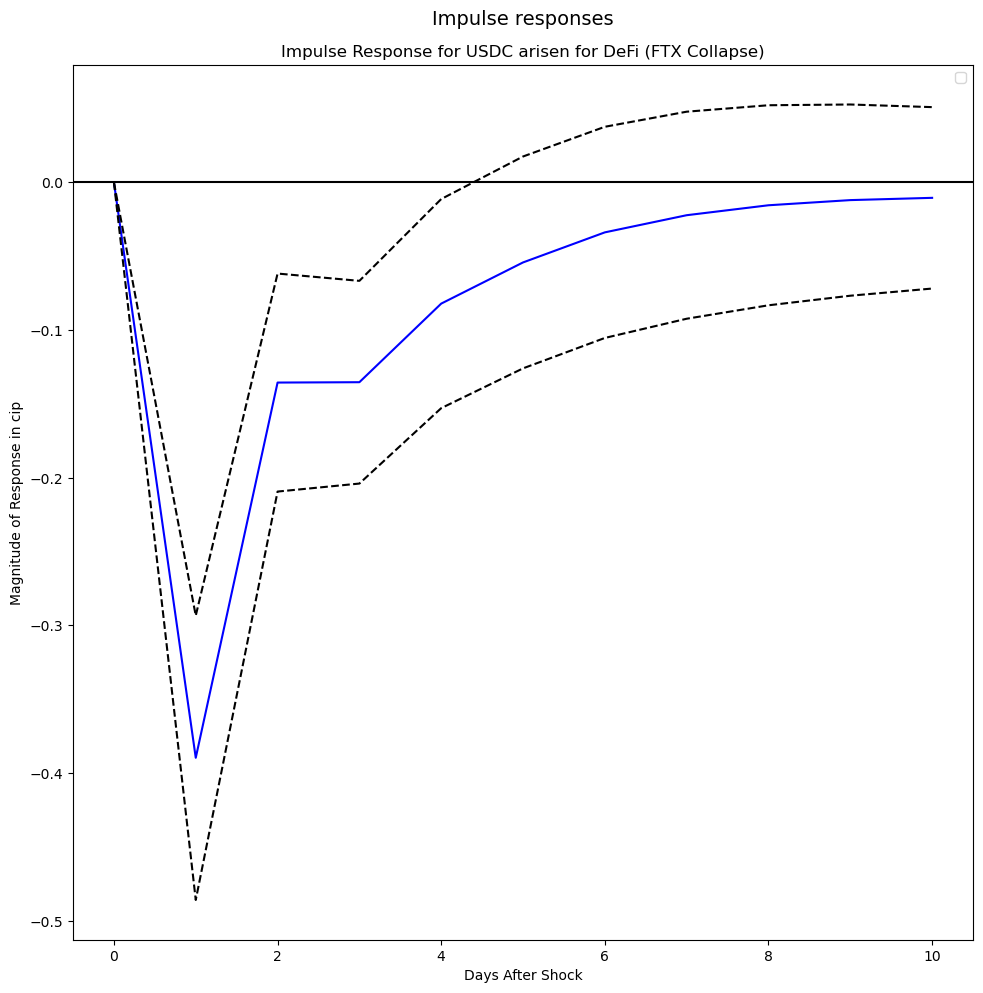

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


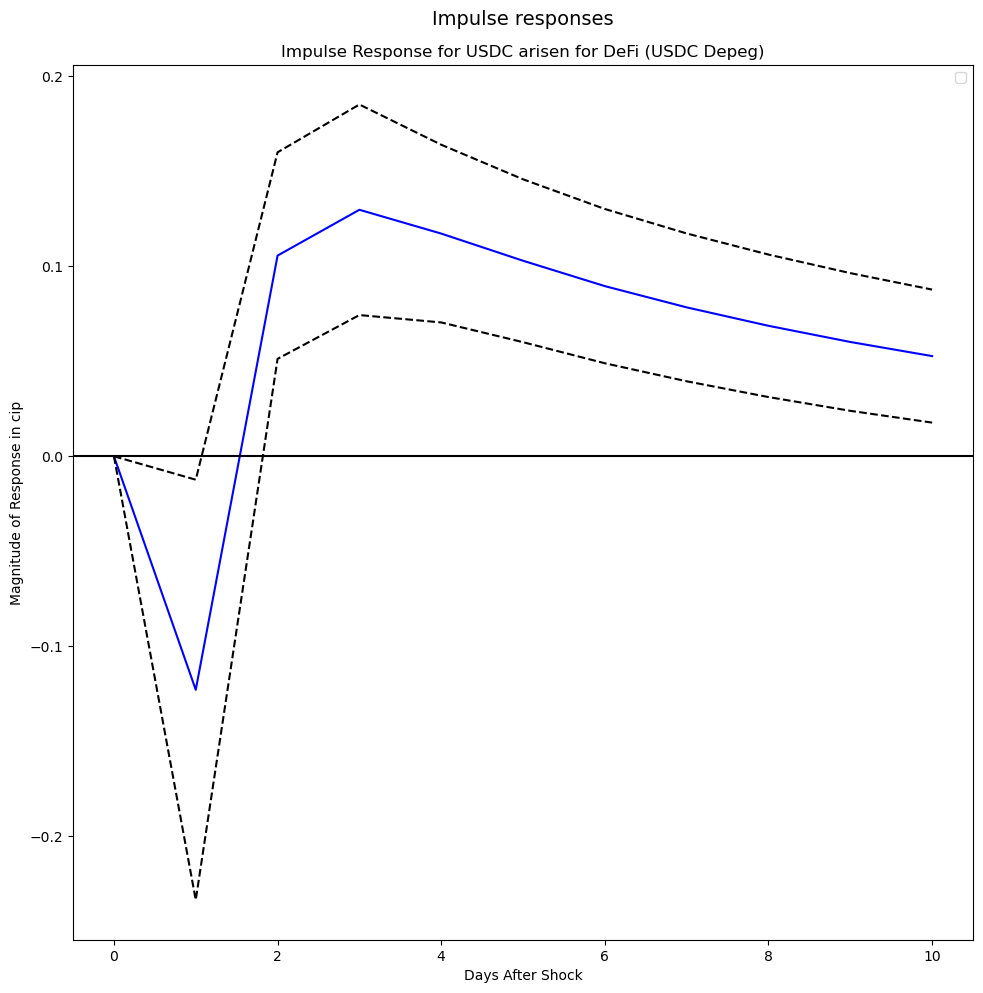

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['Unnamed: 0', 'datetime', 'fundingRate', 'price_spot', 'volume_spot', 'price_perps', 'volume_perps', 'trades_perps', 'Tbill_1_month', 'Tbill_2_month', 'Tbill_3_month', 'usdc_cip', 'synthetic_rate_1_month', 'difference_1_month', 'vol_btc', 'crisis', 'eth_gas', 'bsc_gas', 'usdc_circulatingsupply']
True


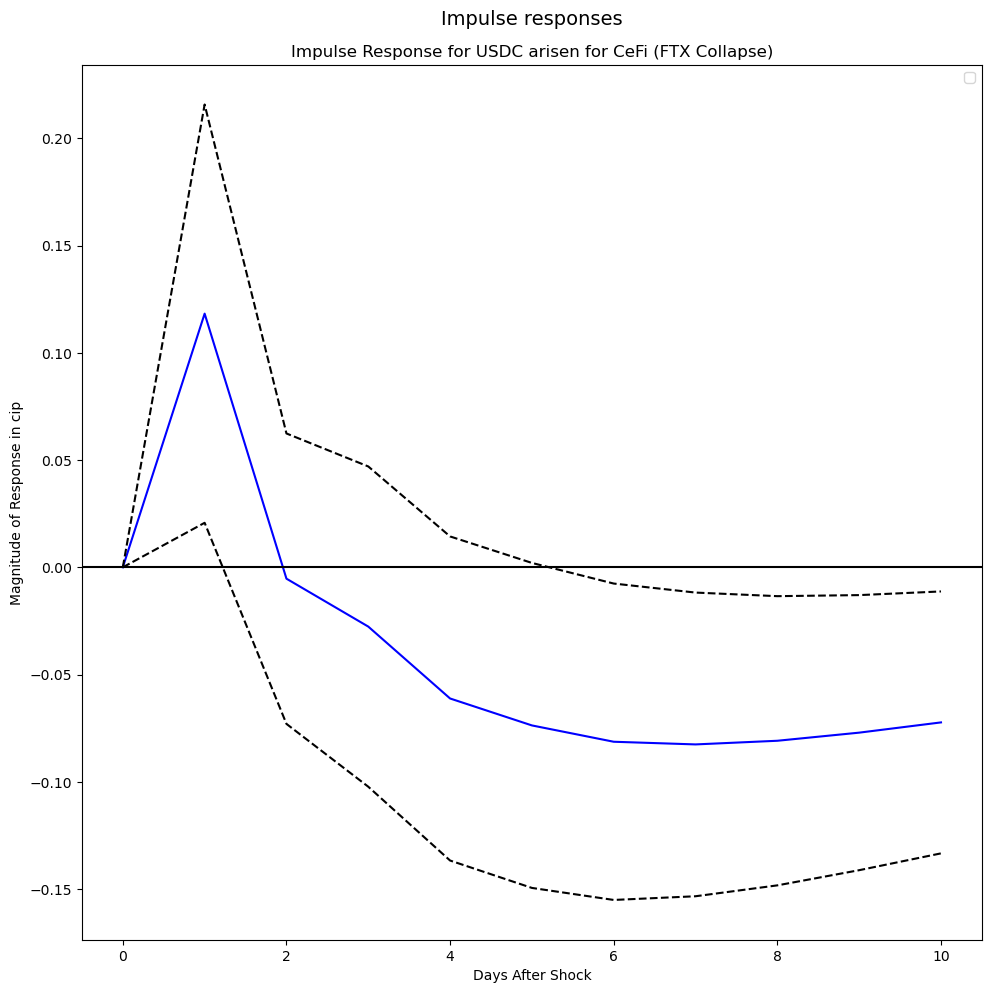

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


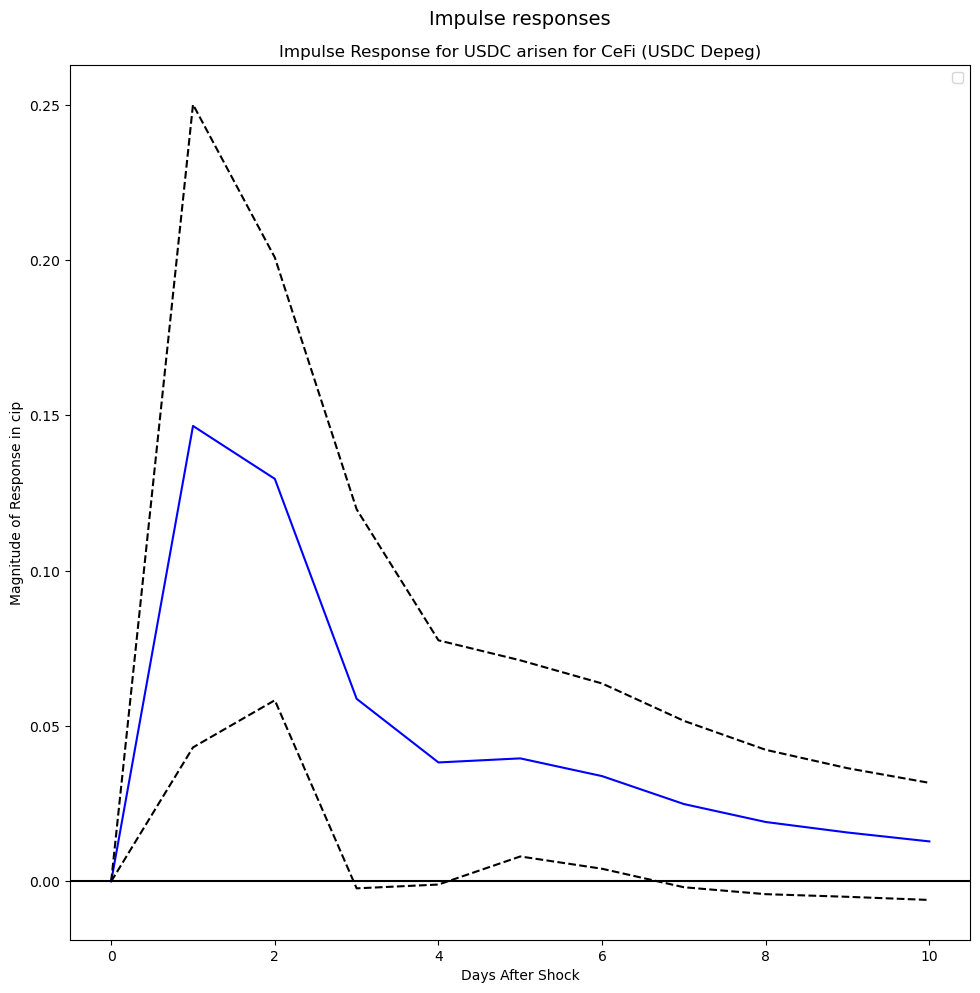

['Unnamed: 0', 'datetime', 'fundingRate', 'price_spot', 'volume_spot', 'price_perps', 'volume_perps', 'Venus_BUSD', 'busd_cip', 'synthetic_rate', 'difference', 'vol_btc', 'crisis', 'eth_gas', 'bsc_gas', 'busd_circulatingsupply']
False
['Unnamed: 0', 'datetime', 'fundingRate', 'price_spot', 'volume_spot', 'price_perps', 'volume_perps', 'Tbill_1_month', 'Tbill_2_month', 'Tbill_3_month', 'busd_cip', 'synthetic_rate_1_month', 'difference_1_month', 'vol_btc', 'crisis', 'eth_gas', 'bsc_gas', 'busd_circulatingsupply']
True


In [51]:
def shock(overall_df, asset):
#   overall_df = df.loc[df['datetime'] >= '2023-01-01'].reset_index(drop=True)
#   print(overall_df.loc[overall_df['crisis'] == 1])

    columns = list(overall_df.columns)
    print(columns)
    print('Tbill_1_month' in columns)
    
    if 'eth_gas' in overall_df.columns: 
        gas_col = 'eth_gas'
    elif 'bsc_gas' in overall_df.columns: 
        gas_col = 'bsc_gas'
            
            
    if asset.upper() == 'BUSD': 
        return
    else:
        if 'Tbill_1_month' in columns:
            type_comparison = 'CeFi'
            df = overall_df[['datetime',  'Tbill_1_month', f'{asset.lower()}_cip', 'vol_btc', 'crisis', gas_col,  f'{asset.lower()}_circulatingsupply']].set_index('datetime')
            
        else:
            type_comparison = 'DeFi'
            df = overall_df[['datetime', f'AAVE_{asset}', f'{asset.lower()}_cip','vol_btc', 'crisis', gas_col, f'{asset.lower()}_circulatingsupply']].set_index('datetime')
    
    if asset.upper() != 'BUSD':
        # FTX Collapse 

        sub_df = df.loc[df.index >= '2022-11-02'].reset_index(drop=True)
        model = VAR(sub_df)
        lag_order = 2 
        results = model.fit(lag_order)
        irf = results.irf(10)
        irf.plot(impulse='crisis', response= f'{asset.lower()}_cip')
        plt.title(f'Impulse Response for {asset} arisen for ' + type_comparison + " (FTX Collapse)")
        plt.xlabel('Days After Shock')
        plt.ylabel('Magnitude of Response in cip')
        plt.legend()
        plt.show()


        # USDC Depeg 
        sub_df = df.loc[df.index >= '2023-03-10'].reset_index(drop=True)
        model = VAR(sub_df)
        lag_order = 2 
        results = model.fit(lag_order)
        irf = results.irf(10) 

        irf.plot(impulse='crisis', response= f'{asset.lower()}_cip')
        plt.title(f'Impulse Response for {asset} arisen for ' + type_comparison + " (USDC Depeg)")
        plt.xlabel('Days After Shock')
        plt.ylabel('Magnitude of Response in cip')
        plt.legend()
        plt.show()

for stablecoin in stablecoins: 
    for i in range(len(asset_dict[stablecoin])):
        shock(asset_dict[stablecoin][i], stablecoin)


# CIP vs Term Structure

/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/442768271.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_1_2'] = (df['busd_2_cip'] - df['busd_1_cip']) * 10000
/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/442768271.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_1_3'] = (df['busd_3_cip'] - df['busd_1_cip']) * 10000


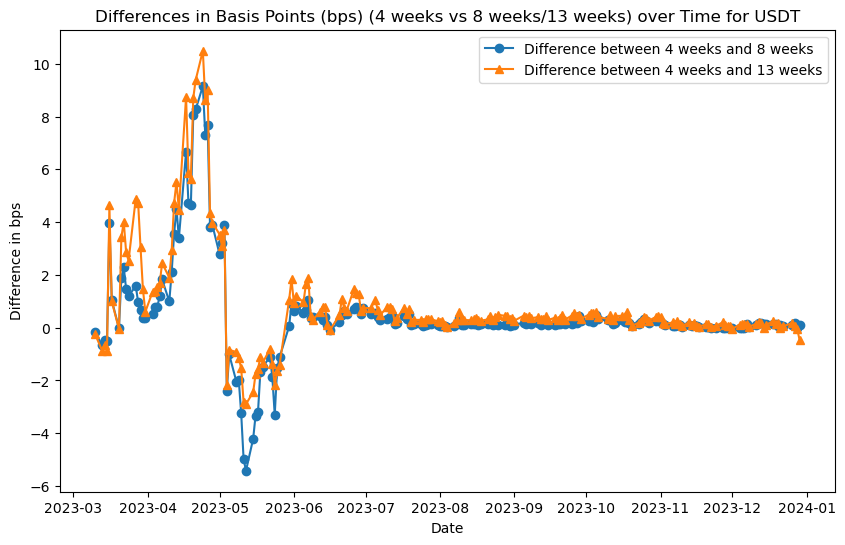

/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/442768271.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_1_2'] = (df['busd_2_cip'] - df['busd_1_cip']) * 10000
/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/442768271.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_1_3'] = (df['busd_3_cip'] - df['busd_1_cip']) * 10000


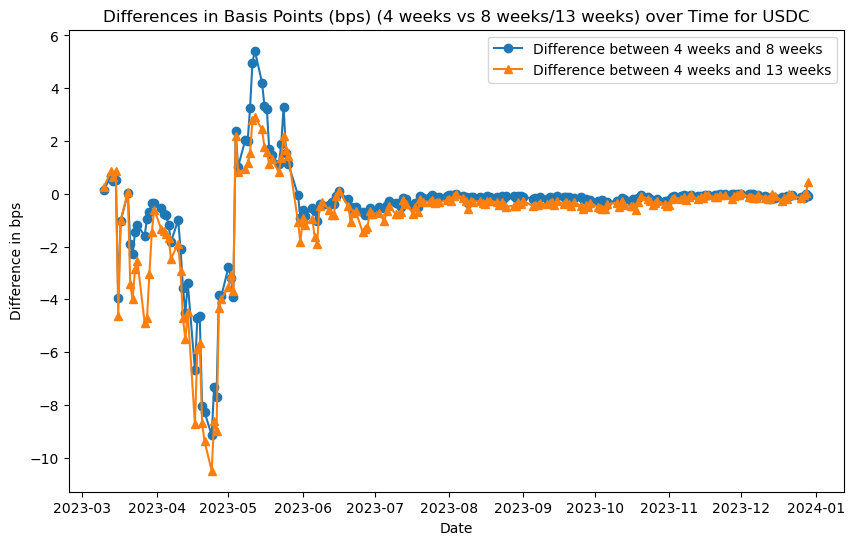

/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/442768271.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_1_2'] = (df['busd_2_cip'] - df['busd_1_cip']) * 10000
/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_4410/442768271.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_1_3'] = (df['busd_3_cip'] - df['busd_1_cip']) * 10000


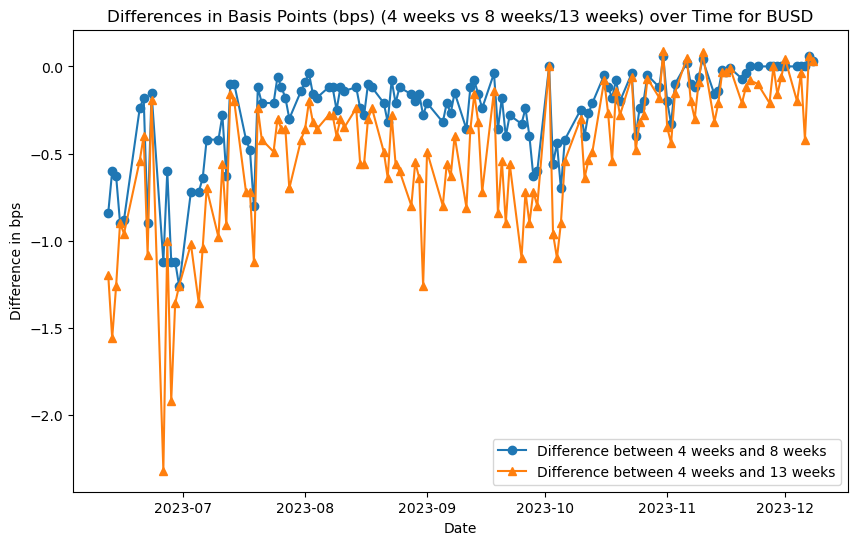

In [52]:
treasuries_dict = {'USDT':  tbill_overall_usdt_df,
 'USDC':  tbill_overall_usdc_df, 
              'BUSD': tbill_overall_busd_df 
             }

def calculate_tbills_cip(overall_df):
    windows = [1, 2, 3]
    cols = ['datetime']
    for time in windows:
        overall_df[f'{asset.lower()}_{time}_cip'] = overall_df.apply(lambda x: calc_cip(x['price_perps'], x['price_spot'], x[f'Tbill_{time}_month'], 365), axis=1)
        overall_df[f'synthetic_rate_{time}_month'] = overall_df.apply(lambda x: calc_synthetic_rate(x['price_perps'], x['price_spot'], x[f'Tbill_{time}_month'], 365), axis=1)
        overall_df[f'difference_{time}_month'] = overall_df[f'Tbill_{time}_month'] - overall_df[f'synthetic_rate_{time}_month']
        cols.append(f'{asset.lower()}_{time}_cip')
    return overall_df[cols]

for stablecoin in stablecoins: 
        df = treasuries_dict[stablecoin]
        df = calculate_tbills_cip(df)
        df['diff_1_2'] = (df['busd_2_cip'] - df['busd_1_cip']) * 10000
        df['diff_1_3'] = (df['busd_3_cip'] - df['busd_1_cip']) * 10000
        
        usdc_depeg_date =  '2023-03-10'
        sub_df = df.loc[df['datetime']>= usdc_depeg_date]
        
        plt.figure(figsize=(10, 6))
        plt.plot(sub_df['datetime'],sub_df['diff_1_2'], marker='o', label='Difference between 4 weeks and 8 weeks')
        plt.plot(sub_df['datetime'], sub_df['diff_1_3'], marker='^', label='Difference between 4 weeks and 13 weeks')
        plt.title(f'Differences in Basis Points (bps) (4 weeks vs 8 weeks/13 weeks) over Time for {stablecoin}')
        plt.xlabel('Date')
        plt.ylabel('Difference in bps')
        plt.legend()
        plt.show()
        
        



# Linear Regression


In [53]:
for stablecoin in stablecoins: 
    for i in range(len(asset_dict[stablecoin])):
        print(asset_dict[stablecoin][i].columns, stablecoin)

Index(['Unnamed: 0', 'datetime', 'fundingRate', 'price_spot', 'volume_spot',
       'price_perps', 'volume_perps', 'trades_perps', 'Day', 'AAVE_USDT',
       'usdt_cip', 'synthetic_rate', 'vol_btc', 'crisis', 'eth_gas', 'bsc_gas',
       'usdt_circulatingsupply', 'volume', 'cip_change', 'volume_change',
       'period'],
      dtype='object') USDT
Index(['Unnamed: 0', 'datetime', 'fundingRate', 'price_spot', 'volume_spot',
       'price_perps', 'volume_perps', 'trades_perps', 'Tbill_1_month',
       'Tbill_2_month', 'Tbill_3_month', 'usdt_cip', 'synthetic_rate_1_month',
       'difference_1_month', 'vol_btc', 'crisis', 'eth_gas', 'bsc_gas',
       'usdt_circulatingsupply'],
      dtype='object') USDT
Index(['Unnamed: 0', 'datetime', 'fundingRate', 'price_spot', 'volume_spot',
       'price_perps', 'volume_perps', 'trades_perps', 'Day', 'AAVE_USDC',
       'usdc_cip', 'synthetic_rate', 'vol_btc', 'crisis', 'eth_gas', 'bsc_gas',
       'usdc_circulatingsupply'],
      dtype='object') USD

In [54]:
def regression(overall_df, asset):
    if 'eth_gas' in overall_df.columns: 
        gas_col = 'eth_gas'
    elif 'bsc_gas' in overall_df.columns: 
        gas_col = 'bsc_gas'
        
    overall_df['volume'] = overall_df['volume_perps'] + overall_df['volume_spot']
    
    columns = ['crisis', gas_col , f'{asset.lower()}_circulatingsupply', 'vol_btc', 'volume']
    
    
    numerical_cols = [gas_col, f'{asset.lower()}_circulatingsupply', 'vol_btc', 'volume']
    
    for col in numerical_cols: 
        overall_df[col]= np.log(overall_df[col]) 
    overall_df = overall_df.dropna()
    
    y = overall_df[ f'{asset.lower()}_cip']
    print(overall_df.columns)
    
    if asset != "BUSD":
        if 'Tbill_1_month' in overall_df.columns: 
            columns.append('Tbill_1_month')
            x = overall_df[columns].astype(float)
        else: 
            columns.append(f'AAVE_{asset}')
            x = overall_df[columns].astype(float)
    else: 
        if 'Tbill_1_month' in overall_df.columns: 
            columns.append('Tbill_1_month')
            x = overall_df[columns].astype(float)
        else: 
            columns.append(f'Venus_{asset}')
            x = overall_df[columns].astype(float)
    asset = asset.upper()
    print(x.isna().sum(), y.isna().sum())
    model = sm.OLS(y,x).fit()

    summary = model.summary()
 
    print(summary)

    return summary



usdt_regression_df = pd.DataFrame()
usdc_regression_df = pd.DataFrame()
busd_regression_df = pd.DataFrame()

for stablecoin in stablecoins:
    result_dfs = []
    for i in range(len(asset_dict[stablecoin])):
        result_df = regression(asset_dict[stablecoin][i], stablecoin)
        

Index(['Unnamed: 0', 'datetime', 'fundingRate', 'price_spot', 'volume_spot',
       'price_perps', 'volume_perps', 'trades_perps', 'Day', 'AAVE_USDT',
       'usdt_cip', 'synthetic_rate', 'vol_btc', 'crisis', 'eth_gas', 'bsc_gas',
       'usdt_circulatingsupply', 'volume', 'cip_change', 'volume_change',
       'period'],
      dtype='object')
crisis                    0
eth_gas                   0
usdt_circulatingsupply    0
vol_btc                   0
volume                    0
AAVE_USDT                 0
dtype: int64 0
                                 OLS Regression Results                                
Dep. Variable:               usdt_cip   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                              602.4
Date:                Fri, 26 Apr 2024   Prob (F-statistic):                   9.39e-150
Time:                        17:

/Users/patsy/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/patsy/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
